In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import exotic_jedi as jedi

In [2]:
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
os.environ['CRDS_PATH'] = '/YOUR/CRDS/PATH/crds_cache/'

In [3]:
from jwst import datamodels
from jwst.pipeline import calwebb_detector1
from crds import get_default_context
print('Using crds context={}'.format(get_default_context()))

from exotic_jedi.stage_1 import CustomBiasStep, DestripingGroupsStep

Using crds context=jwst_1069.pmap


Point to files

In [4]:
# Data and version config.
data_dir = '/PATH/TO/YOUR/DATA/'

data_chunks = sorted(glob.glob(data_dir+'*nrs1_uncal.fits'))

In [5]:
data_chunk_names=[]
for file in range(len(data_chunks)):
    file_name = data_chunks[file].split('/')[-1].split('uncal.fits')[0][:-1]
    data_chunk_names.append(file_name)
print(data_chunk_names)

['jw02512010001_04102_00001-seg001_nrs2', 'jw02512010001_04102_00001-seg002_nrs2', 'jw02512010001_04102_00001-seg003_nrs2', 'jw02512010001_04102_00001-seg004_nrs2']


Point to where we want results saved

In [13]:
reduction_dir = '/your_directory/PLANET_VISIT/'
ancillary_dir = os.path.join(reduction_dir, 'ancillary')
version_dir = os.path.join(reduction_dir, 'reduction_v1')
stage_1_dir = os.path.join(version_dir, 'stage_1')
for _dir in [version_dir, stage_1_dir]:
    if not os.path.exists(_dir):
        os.mkdir(_dir)

In [14]:
### Instantiate STScI steps for NIRSpec stage 1.
stsci_group_scale = calwebb_detector1.group_scale_step.GroupScaleStep()
stsci_dq_init = calwebb_detector1.dq_init_step.DQInitStep()
stsci_saturation = calwebb_detector1.saturation_step.SaturationStep()
stsci_superbias = calwebb_detector1.superbias_step.SuperBiasStep()
stsci_refpix = calwebb_detector1.refpix_step.RefPixStep()
stsci_linearity = calwebb_detector1.linearity_step.LinearityStep()
stsci_dark_current = calwebb_detector1.dark_current_step.DarkCurrentStep()
stsci_jump = calwebb_detector1.jump_step.JumpStep()
stsci_ramp_fit = calwebb_detector1.ramp_fit_step.RampFitStep()
stsci_gain_scale = calwebb_detector1.gain_scale_step.GainScaleStep()

# Instantiate Custom steps for NIRSpec stage 1.
custom_bias = CustomBiasStep()
custom_destriping_groups = DestripingGroupsStep()

# Iterate data chunks.
for data_chunk_name in data_chunk_names:
    print()
    print()
    print('\n=======================\n')
    print('\n========= ~ ~ ~ ~ ~ ~ ~\n')
    print('\n========= Working on {} =========\n'.format(data_chunk_name))
    print('\n========= ~ ~ ~ ~ ~ ~ ~ \n')
    print('\n========================\n')
    print()
    print()

          
    # Read in chunk.
    raw_data_chunk = os.path.join(
        data_dir, '{}_uncal.fits'.format(data_chunk_name))
    dm_raw = datamodels.RampModel(raw_data_chunk)

    # Stage 1 reduction.
    proc = stsci_group_scale.call(dm_raw)
    proc = stsci_dq_init.call(dm_raw)
    proc = stsci_saturation.call(proc, n_pix_grow_sat=1)
    # proc = stsci_superbias.call(proc)
    proc = custom_bias.call(proc)
    proc = stsci_refpix.call(proc, odd_even_columns=True)
    proc = stsci_linearity.call(proc)
    proc = stsci_dark_current.call(proc)
    proc = stsci_jump.call(
        proc, rejection_threshold=15.,
        flag_4_neighbors=True, min_jump_to_flag_neighbors=10.,
        three_group_rejection_threshold=15., four_group_rejection_threshold=15.,
        expand_large_events=False, skip=False)
    proc = custom_destriping_groups.call(
        proc,
        start_trace_col=5, end_trace_col=2042,
        poly_order=2, n_sigma_trace_mask=15.,
        dq_bits=[0, 1, 2, 10, 11, 13, 19],
        draw_psf_fits=False,
        keep_mean_bkd_level=False,
        draw_mask=False)
    _, proc = stsci_ramp_fit.call(proc)
    stage_1_output = stsci_gain_scale.call(proc)
    stage_1_output.save(path=os.path.join(
        stage_1_dir, '{}_stage_1.fits'.format(data_chunk_name)))

2023-03-28 20:13:19,780 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2023-03-28 20:13:19,784 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-03-28 20:13:19,787 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2023-03-28 20:13:19,789 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2023-03-28 20:13:19,792 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2023-03-28 20:13:19,794 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2023-03-28 20:13:19,797 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2023-03-28 20:13:19,800 - stpipe.JumpStep - INFO - JumpStep instance created.
2023-03-28 20:13:19,802 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2023-03-28 20:13:19,805 - stpipe.GainScaleStep - INFO - GainScaleStep instance created.
2023-03-28 20:13:19,807 - stpipe.CustomBiasStep - INFO - CustomBiasStep instance created.
2023-03-28 20:13:19,810 - stpipe.DestripingGroup






========= ~ ~ ~ ~ ~ ~ ~


========= Working on jw02512010001_04102_00001-seg001_nrs2 =========


========= ~ ~ ~ ~ ~ ~ ~ 







2023-03-28 20:13:36,089 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2023-03-28 20:13:39,142 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args (<RampModel(1524, 3, 32, 2048) from jw02512010001_04102_00001-seg001_nrs2_uncal.fits>,).
2023-03-28 20:13:39,144 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-03-28 20:13:50,843 - stpipe.GroupScaleStep - INFO - NFRAMES and FRMDIVSR are equal; correction not needed
2023-03-28 20:13:50,845 - stpipe.GroupScaleStep - INFO - Step will be skipped
2023-03-28 20:13:50,849 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep done
2023-03-28 20:13:50,871 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-03-28 20:13:51,436 - st

2023-03-28 20:16:16,273 - stpipe.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 40.0, 'three_group_rejection_threshold': 40.0, 'four_group_rejection_threshold': 40.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 40.0, 'after_jump_flag_dn1': 1000, 'after_jump_flag_time1': 90, 'after_jump_flag_dn2': 0, 'after_jump_flag_time2': 0, 'min_sat_area': 1, 'min_jump_area': 5, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}
2023-03-28 20:16:16,298 - stpipe.jump - INFO - CR rejection threshold = 40 sigma
2023-03-28 20:16:16,323 - stpipe.jump - INFO - Using GAIN reference file: /home/ym20900/crds_cache/ref

2023-03-28 20:16:36,585 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:36,586 - stpipe.jump - INFO - Working on integration 21:
2023-03-28 20:16:36,606 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:36,616 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:36,617 - stpipe.jump - INFO - Working on integration 22:
2023-03-28 20:16:36,638 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:36,644 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:36,646 - stpipe.jump - INFO - Working on integration 23:
2023-03-28 20:16:36,666 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 20:16:37,403 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:37,404 - stpipe.jump - INFO - Working on integration 46:
2023-03-28 20:16:37,431 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:37,439 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:37,440 - stpipe.jump - INFO - Working on integration 47:
2023-03-28 20:16:37,467 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:37,475 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:37,477 - stpipe.jump - INFO - Working on integration 48:
2023-03-28 20:16:37,505 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 20:16:38,215 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:38,216 - stpipe.jump - INFO - Working on integration 71:
2023-03-28 20:16:38,237 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:38,243 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:38,244 - stpipe.jump - INFO - Working on integration 72:
2023-03-28 20:16:38,265 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:38,271 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:38,272 - stpipe.jump - INFO - Working on integration 73:
2023-03-28 20:16:38,294 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 20:16:39,255 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:39,257 - stpipe.jump - INFO - Working on integration 96:
2023-03-28 20:16:39,291 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:39,302 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:39,304 - stpipe.jump - INFO - Working on integration 97:
2023-03-28 20:16:39,363 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:39,373 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:39,376 - stpipe.jump - INFO - Working on integration 98:
2023-03-28 20:16:39,410 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 20:16:40,565 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:40,568 - stpipe.jump - INFO - Working on integration 121:
2023-03-28 20:16:40,599 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:40,610 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:40,612 - stpipe.jump - INFO - Working on integration 122:
2023-03-28 20:16:40,641 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:40,650 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:40,652 - stpipe.jump - INFO - Working on integration 123:
2023-03-28 20:16:40,685 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:41,897 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:41,899 - stpipe.jump - INFO - Working on integration 146:
2023-03-28 20:16:41,933 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:41,948 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:41,950 - stpipe.jump - INFO - Working on integration 147:
2023-03-28 20:16:41,986 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:41,994 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:41,996 - stpipe.jump - INFO - Working on integration 148:
2023-03-28 20:16:42,026 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:42,946 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:42,947 - stpipe.jump - INFO - Working on integration 171:
2023-03-28 20:16:42,970 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:42,976 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:42,977 - stpipe.jump - INFO - Working on integration 172:
2023-03-28 20:16:42,998 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:43,003 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:43,005 - stpipe.jump - INFO - Working on integration 173:
2023-03-28 20:16:43,025 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:43,655 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:43,657 - stpipe.jump - INFO - Working on integration 196:
2023-03-28 20:16:43,682 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:43,691 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:43,693 - stpipe.jump - INFO - Working on integration 197:
2023-03-28 20:16:43,718 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:43,727 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:43,729 - stpipe.jump - INFO - Working on integration 198:
2023-03-28 20:16:43,756 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:44,411 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:44,412 - stpipe.jump - INFO - Working on integration 221:
2023-03-28 20:16:44,443 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:44,451 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:44,452 - stpipe.jump - INFO - Working on integration 222:
2023-03-28 20:16:44,483 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:44,493 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:44,495 - stpipe.jump - INFO - Working on integration 223:
2023-03-28 20:16:44,520 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:45,217 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:45,218 - stpipe.jump - INFO - Working on integration 246:
2023-03-28 20:16:45,237 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:45,242 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:45,243 - stpipe.jump - INFO - Working on integration 247:
2023-03-28 20:16:45,262 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:45,268 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:45,269 - stpipe.jump - INFO - Working on integration 248:
2023-03-28 20:16:45,290 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:45,970 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:45,972 - stpipe.jump - INFO - Working on integration 271:
2023-03-28 20:16:45,992 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:45,998 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:45,999 - stpipe.jump - INFO - Working on integration 272:
2023-03-28 20:16:46,019 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:46,024 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:46,025 - stpipe.jump - INFO - Working on integration 273:
2023-03-28 20:16:46,045 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:46,761 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:46,762 - stpipe.jump - INFO - Working on integration 296:
2023-03-28 20:16:46,787 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:46,795 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:46,797 - stpipe.jump - INFO - Working on integration 297:
2023-03-28 20:16:46,822 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:46,829 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:46,831 - stpipe.jump - INFO - Working on integration 298:
2023-03-28 20:16:46,856 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:47,546 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:47,547 - stpipe.jump - INFO - Working on integration 321:
2023-03-28 20:16:47,567 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:47,573 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:47,574 - stpipe.jump - INFO - Working on integration 322:
2023-03-28 20:16:47,594 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:47,602 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:47,603 - stpipe.jump - INFO - Working on integration 323:
2023-03-28 20:16:47,625 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:48,394 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:48,395 - stpipe.jump - INFO - Working on integration 346:
2023-03-28 20:16:48,428 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:48,437 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:48,439 - stpipe.jump - INFO - Working on integration 347:
2023-03-28 20:16:48,471 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:48,479 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:48,481 - stpipe.jump - INFO - Working on integration 348:
2023-03-28 20:16:48,508 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:49,300 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:49,301 - stpipe.jump - INFO - Working on integration 371:
2023-03-28 20:16:49,321 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:49,329 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:49,330 - stpipe.jump - INFO - Working on integration 372:
2023-03-28 20:16:49,351 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:49,357 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:49,358 - stpipe.jump - INFO - Working on integration 373:
2023-03-28 20:16:49,379 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:50,065 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:50,066 - stpipe.jump - INFO - Working on integration 396:
2023-03-28 20:16:50,086 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:50,091 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:50,092 - stpipe.jump - INFO - Working on integration 397:
2023-03-28 20:16:50,111 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:50,117 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:50,118 - stpipe.jump - INFO - Working on integration 398:
2023-03-28 20:16:50,137 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:50,865 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:50,866 - stpipe.jump - INFO - Working on integration 421:
2023-03-28 20:16:50,894 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:50,901 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:50,902 - stpipe.jump - INFO - Working on integration 422:
2023-03-28 20:16:50,927 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:50,934 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:50,936 - stpipe.jump - INFO - Working on integration 423:
2023-03-28 20:16:50,959 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:51,681 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:51,683 - stpipe.jump - INFO - Working on integration 446:
2023-03-28 20:16:51,706 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:51,713 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:51,714 - stpipe.jump - INFO - Working on integration 447:
2023-03-28 20:16:51,737 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:51,743 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:51,744 - stpipe.jump - INFO - Working on integration 448:
2023-03-28 20:16:51,768 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:52,462 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:52,463 - stpipe.jump - INFO - Working on integration 471:
2023-03-28 20:16:52,494 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:52,502 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:52,503 - stpipe.jump - INFO - Working on integration 472:
2023-03-28 20:16:52,533 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:52,540 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:52,542 - stpipe.jump - INFO - Working on integration 473:
2023-03-28 20:16:52,568 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:53,231 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:53,232 - stpipe.jump - INFO - Working on integration 496:
2023-03-28 20:16:53,262 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:53,269 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:53,270 - stpipe.jump - INFO - Working on integration 497:
2023-03-28 20:16:53,300 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:53,308 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:53,310 - stpipe.jump - INFO - Working on integration 498:
2023-03-28 20:16:53,340 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:54,055 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:54,056 - stpipe.jump - INFO - Working on integration 521:
2023-03-28 20:16:54,076 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:54,081 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:54,082 - stpipe.jump - INFO - Working on integration 522:
2023-03-28 20:16:54,101 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:54,106 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:54,107 - stpipe.jump - INFO - Working on integration 523:
2023-03-28 20:16:54,127 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:54,856 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:54,858 - stpipe.jump - INFO - Working on integration 546:
2023-03-28 20:16:54,881 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:54,889 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:54,892 - stpipe.jump - INFO - Working on integration 547:
2023-03-28 20:16:54,917 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:54,923 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:54,925 - stpipe.jump - INFO - Working on integration 548:
2023-03-28 20:16:54,946 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:55,624 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:55,626 - stpipe.jump - INFO - Working on integration 571:
2023-03-28 20:16:55,662 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:55,671 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:55,673 - stpipe.jump - INFO - Working on integration 572:
2023-03-28 20:16:55,702 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:55,711 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:55,714 - stpipe.jump - INFO - Working on integration 573:
2023-03-28 20:16:55,752 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:56,515 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:56,517 - stpipe.jump - INFO - Working on integration 596:
2023-03-28 20:16:56,545 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:56,553 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:56,555 - stpipe.jump - INFO - Working on integration 597:
2023-03-28 20:16:56,584 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:56,592 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:56,594 - stpipe.jump - INFO - Working on integration 598:
2023-03-28 20:16:56,624 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:57,363 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:57,364 - stpipe.jump - INFO - Working on integration 621:
2023-03-28 20:16:57,389 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:57,397 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:57,399 - stpipe.jump - INFO - Working on integration 622:
2023-03-28 20:16:57,421 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:57,429 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:57,430 - stpipe.jump - INFO - Working on integration 623:
2023-03-28 20:16:57,451 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:58,181 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:58,182 - stpipe.jump - INFO - Working on integration 646:
2023-03-28 20:16:58,202 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:58,207 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:58,208 - stpipe.jump - INFO - Working on integration 647:
2023-03-28 20:16:58,227 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:58,233 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:58,234 - stpipe.jump - INFO - Working on integration 648:
2023-03-28 20:16:58,253 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:58,996 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:58,997 - stpipe.jump - INFO - Working on integration 671:
2023-03-28 20:16:59,017 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:59,022 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:59,023 - stpipe.jump - INFO - Working on integration 672:
2023-03-28 20:16:59,043 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:59,049 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:59,050 - stpipe.jump - INFO - Working on integration 673:
2023-03-28 20:16:59,070 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:16:59,717 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:59,719 - stpipe.jump - INFO - Working on integration 696:
2023-03-28 20:16:59,744 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:59,752 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:59,754 - stpipe.jump - INFO - Working on integration 697:
2023-03-28 20:16:59,779 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:16:59,787 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:16:59,789 - stpipe.jump - INFO - Working on integration 698:
2023-03-28 20:16:59,816 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:00,568 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:00,570 - stpipe.jump - INFO - Working on integration 721:
2023-03-28 20:17:00,600 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:00,607 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:00,609 - stpipe.jump - INFO - Working on integration 722:
2023-03-28 20:17:00,638 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:00,646 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:00,648 - stpipe.jump - INFO - Working on integration 723:
2023-03-28 20:17:00,677 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:01,367 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:01,368 - stpipe.jump - INFO - Working on integration 746:
2023-03-28 20:17:01,392 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:01,401 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:01,403 - stpipe.jump - INFO - Working on integration 747:
2023-03-28 20:17:01,425 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:01,432 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:01,433 - stpipe.jump - INFO - Working on integration 748:
2023-03-28 20:17:01,455 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:02,244 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:02,245 - stpipe.jump - INFO - Working on integration 771:
2023-03-28 20:17:02,275 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:02,283 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:02,284 - stpipe.jump - INFO - Working on integration 772:
2023-03-28 20:17:02,305 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:02,311 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:02,312 - stpipe.jump - INFO - Working on integration 773:
2023-03-28 20:17:02,333 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:03,036 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:03,037 - stpipe.jump - INFO - Working on integration 796:
2023-03-28 20:17:03,056 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:03,061 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:03,062 - stpipe.jump - INFO - Working on integration 797:
2023-03-28 20:17:03,082 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:03,087 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:03,088 - stpipe.jump - INFO - Working on integration 798:
2023-03-28 20:17:03,107 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:03,888 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:03,890 - stpipe.jump - INFO - Working on integration 821:
2023-03-28 20:17:03,914 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:03,922 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:03,925 - stpipe.jump - INFO - Working on integration 822:
2023-03-28 20:17:03,950 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:03,958 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:03,960 - stpipe.jump - INFO - Working on integration 823:
2023-03-28 20:17:03,982 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:04,621 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:04,622 - stpipe.jump - INFO - Working on integration 846:
2023-03-28 20:17:04,643 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:04,651 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:04,653 - stpipe.jump - INFO - Working on integration 847:
2023-03-28 20:17:04,676 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:04,682 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:04,683 - stpipe.jump - INFO - Working on integration 848:
2023-03-28 20:17:04,703 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:05,493 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:05,494 - stpipe.jump - INFO - Working on integration 871:
2023-03-28 20:17:05,524 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:05,533 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:05,534 - stpipe.jump - INFO - Working on integration 872:
2023-03-28 20:17:05,564 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:05,575 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:05,576 - stpipe.jump - INFO - Working on integration 873:
2023-03-28 20:17:05,607 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:06,652 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:06,654 - stpipe.jump - INFO - Working on integration 896:
2023-03-28 20:17:06,679 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:06,684 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:06,685 - stpipe.jump - INFO - Working on integration 897:
2023-03-28 20:17:06,707 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:06,713 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:06,715 - stpipe.jump - INFO - Working on integration 898:
2023-03-28 20:17:06,735 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:07,458 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:07,459 - stpipe.jump - INFO - Working on integration 921:
2023-03-28 20:17:07,478 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:07,484 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:07,485 - stpipe.jump - INFO - Working on integration 922:
2023-03-28 20:17:07,505 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:07,510 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:07,511 - stpipe.jump - INFO - Working on integration 923:
2023-03-28 20:17:07,531 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:08,412 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:08,413 - stpipe.jump - INFO - Working on integration 946:
2023-03-28 20:17:08,433 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:08,438 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:08,439 - stpipe.jump - INFO - Working on integration 947:
2023-03-28 20:17:08,458 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:08,464 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:08,465 - stpipe.jump - INFO - Working on integration 948:
2023-03-28 20:17:08,485 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:09,304 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:09,305 - stpipe.jump - INFO - Working on integration 971:
2023-03-28 20:17:09,325 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:09,331 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:09,332 - stpipe.jump - INFO - Working on integration 972:
2023-03-28 20:17:09,351 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:09,358 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:09,359 - stpipe.jump - INFO - Working on integration 973:
2023-03-28 20:17:09,379 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:10,068 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:10,069 - stpipe.jump - INFO - Working on integration 996:
2023-03-28 20:17:10,092 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:10,099 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:10,101 - stpipe.jump - INFO - Working on integration 997:
2023-03-28 20:17:10,124 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:10,132 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:10,133 - stpipe.jump - INFO - Working on integration 998:
2023-03-28 20:17:10,156 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 20:17:10,799 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:10,800 - stpipe.jump - INFO - Working on integration 1021:
2023-03-28 20:17:10,822 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:10,828 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:10,830 - stpipe.jump - INFO - Working on integration 1022:
2023-03-28 20:17:10,850 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:10,857 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:10,859 - stpipe.jump - INFO - Working on integration 1023:
2023-03-28 20:17:10,879 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:11,662 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:11,663 - stpipe.jump - INFO - Working on integration 1046:
2023-03-28 20:17:11,682 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:11,688 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:11,688 - stpipe.jump - INFO - Working on integration 1047:
2023-03-28 20:17:11,708 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:11,713 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:11,713 - stpipe.jump - INFO - Working on integration 1048:
2023-03-28 20:17:11,733 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:12,717 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:12,718 - stpipe.jump - INFO - Working on integration 1071:
2023-03-28 20:17:12,748 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:12,757 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:12,758 - stpipe.jump - INFO - Working on integration 1072:
2023-03-28 20:17:12,789 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:12,798 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:12,800 - stpipe.jump - INFO - Working on integration 1073:
2023-03-28 20:17:12,831 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:13,874 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:13,876 - stpipe.jump - INFO - Working on integration 1096:
2023-03-28 20:17:13,908 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:13,917 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:13,919 - stpipe.jump - INFO - Working on integration 1097:
2023-03-28 20:17:13,952 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:13,960 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:13,962 - stpipe.jump - INFO - Working on integration 1098:
2023-03-28 20:17:13,994 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:14,994 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:14,995 - stpipe.jump - INFO - Working on integration 1121:
2023-03-28 20:17:15,027 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:15,035 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:15,037 - stpipe.jump - INFO - Working on integration 1122:
2023-03-28 20:17:15,068 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:15,076 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:15,078 - stpipe.jump - INFO - Working on integration 1123:
2023-03-28 20:17:15,109 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:15,987 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:15,988 - stpipe.jump - INFO - Working on integration 1146:
2023-03-28 20:17:16,008 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:16,014 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:16,016 - stpipe.jump - INFO - Working on integration 1147:
2023-03-28 20:17:16,036 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:16,042 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:16,043 - stpipe.jump - INFO - Working on integration 1148:
2023-03-28 20:17:16,072 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:16,838 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:16,839 - stpipe.jump - INFO - Working on integration 1171:
2023-03-28 20:17:16,860 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:16,866 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:16,867 - stpipe.jump - INFO - Working on integration 1172:
2023-03-28 20:17:16,887 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:16,893 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:16,894 - stpipe.jump - INFO - Working on integration 1173:
2023-03-28 20:17:16,917 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:17,610 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:17,611 - stpipe.jump - INFO - Working on integration 1196:
2023-03-28 20:17:17,631 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:17,636 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:17,637 - stpipe.jump - INFO - Working on integration 1197:
2023-03-28 20:17:17,666 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:17,675 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:17,676 - stpipe.jump - INFO - Working on integration 1198:
2023-03-28 20:17:17,707 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:18,585 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:18,587 - stpipe.jump - INFO - Working on integration 1221:
2023-03-28 20:17:18,634 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:18,643 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:18,644 - stpipe.jump - INFO - Working on integration 1222:
2023-03-28 20:17:18,676 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:18,684 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:18,685 - stpipe.jump - INFO - Working on integration 1223:
2023-03-28 20:17:18,716 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:19,817 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:19,818 - stpipe.jump - INFO - Working on integration 1246:
2023-03-28 20:17:19,849 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:19,856 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:19,857 - stpipe.jump - INFO - Working on integration 1247:
2023-03-28 20:17:19,887 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:19,897 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:19,899 - stpipe.jump - INFO - Working on integration 1248:
2023-03-28 20:17:19,932 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:21,111 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:21,113 - stpipe.jump - INFO - Working on integration 1271:
2023-03-28 20:17:21,147 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:21,155 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:21,157 - stpipe.jump - INFO - Working on integration 1272:
2023-03-28 20:17:21,189 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:21,197 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:21,198 - stpipe.jump - INFO - Working on integration 1273:
2023-03-28 20:17:21,228 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:22,385 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:22,388 - stpipe.jump - INFO - Working on integration 1296:
2023-03-28 20:17:22,440 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:22,455 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:22,460 - stpipe.jump - INFO - Working on integration 1297:
2023-03-28 20:17:22,516 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:22,529 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:22,534 - stpipe.jump - INFO - Working on integration 1298:
2023-03-28 20:17:22,582 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:23,789 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:23,792 - stpipe.jump - INFO - Working on integration 1321:
2023-03-28 20:17:23,845 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:23,853 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:23,855 - stpipe.jump - INFO - Working on integration 1322:
2023-03-28 20:17:23,901 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:23,911 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:23,912 - stpipe.jump - INFO - Working on integration 1323:
2023-03-28 20:17:23,953 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:25,131 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:25,133 - stpipe.jump - INFO - Working on integration 1346:
2023-03-28 20:17:25,166 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:25,174 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:25,176 - stpipe.jump - INFO - Working on integration 1347:
2023-03-28 20:17:25,209 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:25,219 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:25,221 - stpipe.jump - INFO - Working on integration 1348:
2023-03-28 20:17:25,254 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:26,280 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:26,282 - stpipe.jump - INFO - Working on integration 1371:
2023-03-28 20:17:26,313 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:26,322 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:26,324 - stpipe.jump - INFO - Working on integration 1372:
2023-03-28 20:17:26,354 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:26,363 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:26,364 - stpipe.jump - INFO - Working on integration 1373:
2023-03-28 20:17:26,393 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:27,696 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:27,701 - stpipe.jump - INFO - Working on integration 1396:
2023-03-28 20:17:27,758 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:27,771 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:27,774 - stpipe.jump - INFO - Working on integration 1397:
2023-03-28 20:17:27,813 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:27,822 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:27,824 - stpipe.jump - INFO - Working on integration 1398:
2023-03-28 20:17:27,857 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:29,030 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:29,032 - stpipe.jump - INFO - Working on integration 1421:
2023-03-28 20:17:29,078 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:29,085 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:29,087 - stpipe.jump - INFO - Working on integration 1422:
2023-03-28 20:17:29,117 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:29,126 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:29,128 - stpipe.jump - INFO - Working on integration 1423:
2023-03-28 20:17:29,160 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:30,358 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:30,360 - stpipe.jump - INFO - Working on integration 1446:
2023-03-28 20:17:30,394 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:30,404 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:30,406 - stpipe.jump - INFO - Working on integration 1447:
2023-03-28 20:17:30,435 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:30,445 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:30,448 - stpipe.jump - INFO - Working on integration 1448:
2023-03-28 20:17:30,508 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:31,919 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:31,921 - stpipe.jump - INFO - Working on integration 1471:
2023-03-28 20:17:31,952 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:31,960 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:31,961 - stpipe.jump - INFO - Working on integration 1472:
2023-03-28 20:17:31,993 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:32,001 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:32,002 - stpipe.jump - INFO - Working on integration 1473:
2023-03-28 20:17:32,032 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:33,194 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:33,196 - stpipe.jump - INFO - Working on integration 1496:
2023-03-28 20:17:33,228 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:33,238 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:33,240 - stpipe.jump - INFO - Working on integration 1497:
2023-03-28 20:17:33,272 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:33,280 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:33,282 - stpipe.jump - INFO - Working on integration 1498:
2023-03-28 20:17:33,315 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:17:34,482 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:34,484 - stpipe.jump - INFO - Working on integration 1521:
2023-03-28 20:17:34,529 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:34,541 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:34,546 - stpipe.jump - INFO - Working on integration 1522:
2023-03-28 20:17:34,600 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 20:17:34,615 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 20:17:34,621 - stpipe.jump - INFO - Working on integration 1523:
2023-03-28 20:17:34,675 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 20:18:30,184 - stpipe.DestripingGroupsStep - INFO - ===== Selected group dq flags for mask info =====
2023-03-28 20:18:30,194 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=0 name=DO_NOT_USE.
2023-03-28 20:18:30,197 - stpipe.DestripingGroupsStep - INFO - Selected 809734 pixels with DQ bit=1 name=SATURATED.
2023-03-28 20:18:30,200 - stpipe.DestripingGroupsStep - INFO - Selected 212750 pixels with DQ bit=2 name=JUMP_DET.
2023-03-28 20:18:30,202 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=10 name=DEAD.
2023-03-28 20:18:30,205 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=11 name=HOT.
2023-03-28 20:18:30,207 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=13 name=LOW_QE.
2023-03-28 20:18:30,210 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=19 name=NO_GAIN_VALUE.
2023-03-28 20:18:30,212 - stpipe.DestripingGroupsStep - INFO - Total pixel fraction selected=0.341 %
2023-

2023-03-28 20:19:58,329 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:19:58,457 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:19:58,459 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:19:58,585 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:

2023-03-28 20:20:00,269 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:00,273 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:00,421 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:00,425 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:02,900 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:02,908 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:03,183 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:03,186 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:05,638 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:05,640 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:05,753 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:05,755 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:07,855 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:07,859 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:08,080 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:08,086 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:11,359 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:11,363 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:11,571 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:11,575 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:14,857 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:14,860 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:15,063 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:15,068 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:18,333 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:18,336 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:18,538 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:18,542 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:21,337 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:21,340 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:21,578 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:21,584 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:25,121 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:25,133 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:25,384 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:25,389 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:28,865 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:28,868 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:29,134 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:29,137 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:31,586 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:31,589 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:31,817 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:31,822 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:35,216 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:35,220 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:35,373 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:35,376 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:37,815 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:37,818 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:37,987 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:37,990 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:40,893 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:40,898 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:41,072 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:41,075 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:42,869 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:42,872 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:42,997 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:43,000 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:46,354 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:46,359 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:46,627 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:46,631 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:50,157 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:50,163 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:50,464 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:50,470 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:54,236 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:54,245 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:54,587 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:54,591 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:20:58,220 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:58,227 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:58,675 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:20:58,679 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:01,054 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:01,057 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:01,200 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:01,202 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:03,521 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:03,530 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:03,696 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:03,703 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:05,861 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:05,863 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:05,979 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:05,982 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:07,915 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:07,917 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:08,037 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:08,040 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:11,161 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:11,164 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:11,293 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:11,296 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:13,220 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:13,223 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:13,349 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:13,351 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:15,193 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:15,195 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:15,319 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:15,322 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:17,190 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:17,193 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:17,320 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:17,323 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:19,200 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:19,202 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:19,323 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:19,325 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:21,287 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:21,290 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:21,422 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:21,425 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:23,272 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:23,274 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:23,396 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:23,399 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:25,397 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:25,399 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:25,527 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:25,529 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:27,354 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:27,356 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:27,486 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:27,488 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:29,300 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:29,302 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:29,422 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:29,425 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:31,421 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:31,423 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:31,549 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:31,552 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:33,389 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:33,392 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:33,517 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:33,521 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:35,813 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:35,818 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:35,991 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:35,996 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:37,836 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:37,840 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:37,982 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:37,989 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:39,865 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:39,868 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:40,012 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:40,017 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:41,853 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:41,856 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:41,981 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:41,985 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:44,238 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:44,244 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:44,392 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:44,395 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:46,388 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:46,391 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:46,516 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:46,519 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:48,462 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:48,465 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:48,591 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:48,594 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:50,573 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:50,576 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:50,699 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:50,702 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:52,683 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:52,685 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:52,806 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:52,808 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:55,216 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:55,219 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:55,347 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:55,350 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:57,165 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:57,169 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:57,308 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:57,311 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:21:59,143 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:59,146 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:59,285 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:21:59,290 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:01,205 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:01,207 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:01,451 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:01,457 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:04,939 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:04,941 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:05,060 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:05,063 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:06,972 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:06,974 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:07,094 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:07,097 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:08,993 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:08,996 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:09,111 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:09,113 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:11,162 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:11,164 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:11,282 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:11,285 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:13,159 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:13,161 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:13,281 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:13,283 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:15,132 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:15,135 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:15,251 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:15,253 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:17,412 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:17,416 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:17,637 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:17,641 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:21,186 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:21,191 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:21,404 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:21,407 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:23,629 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:23,631 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:23,757 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:23,759 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:26,241 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:26,244 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:26,368 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:26,371 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:28,144 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:28,149 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:28,300 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:28,304 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:30,128 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:30,133 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:30,282 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:30,287 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:32,140 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:32,143 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:32,293 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:32,298 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:34,216 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:34,221 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:34,366 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:34,371 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:36,266 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:36,270 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:36,423 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:36,429 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:38,325 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:38,331 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:38,474 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:38,480 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:41,347 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:41,351 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:41,492 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:41,497 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:43,323 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:43,327 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:43,468 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:43,471 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:45,777 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:45,779 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:45,896 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:45,899 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:48,027 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:48,031 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:48,251 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:48,255 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:51,122 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:51,125 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:51,249 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:51,252 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:53,113 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:53,115 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:53,236 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:53,239 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:55,106 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:55,109 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:55,229 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:55,233 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:22:58,161 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:58,163 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:58,283 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:22:58,285 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:00,149 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:00,151 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:00,267 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:00,270 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:02,184 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:02,187 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:02,303 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:02,306 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:04,189 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:04,191 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:04,310 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:04,312 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:06,168 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:06,170 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:06,288 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:06,290 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:08,131 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:08,133 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:08,251 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:08,253 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:10,243 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:10,245 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:10,362 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:10,364 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:12,939 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:12,944 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:13,124 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:13,129 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:14,930 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:14,935 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:15,073 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:15,077 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:18,701 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:18,704 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:18,907 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:18,910 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:22,352 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:22,362 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:22,728 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:22,731 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:24,812 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:24,815 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:24,940 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:24,942 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:27,107 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:27,109 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:27,236 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:27,239 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:31,244 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:31,248 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:31,498 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:31,503 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:34,013 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:34,016 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:34,258 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:34,262 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:37,650 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:37,660 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:37,899 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:37,904 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:40,255 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:40,257 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:40,375 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:40,377 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:42,683 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:42,687 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:42,899 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:42,907 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:46,114 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:46,121 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:46,296 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:46,302 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:48,324 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:48,330 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:48,478 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:48,480 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:50,333 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:50,338 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:50,482 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:50,485 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:53,382 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:53,385 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:53,529 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:53,534 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:23:56,513 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:56,515 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:56,642 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:23:56,646 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:24:00,561 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:00,564 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:00,787 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:00,789 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:24:02,948 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:02,951 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:03,155 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:03,158 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:24:06,657 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:06,660 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:06,876 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:06,879 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:24:08,945 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:08,948 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:09,076 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:09,079 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:24:11,046 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:11,049 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:11,175 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:11,178 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:24:13,238 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:13,240 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:13,365 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:13,367 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:24:15,401 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:15,403 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:15,627 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 20:24:15,632 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 20:25:02,590 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:25:04,400 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:25:06,442 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:25:08,392 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:25:55,832 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:25:57,709 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:25:59,424 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:26:01,384 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:26:50,832 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:26:52,638 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:26:54,631 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:26:56,075 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:27:23,222 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:27:24,165 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:27:25,057 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:27:26,002 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:27:55,305 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:27:56,617 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:27:58,024 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:27:59,420 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:28:39,850 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:28:42,038 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:28:43,637 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:28:45,172 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:29:31,385 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:29:32,825 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:29:34,595 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:29:36,097 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:30:21,266 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:30:22,703 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:30:24,577 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:30:26,349 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:31:11,433 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:31:12,894 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:31:14,564 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:31:15,949 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:32:01,355 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:32:02,842 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:32:04,427 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:32:06,132 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:32:50,387 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:32:52,228 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:32:53,814 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:32:55,334 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:33:40,428 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:33:41,808 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:33:43,598 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:33:45,026 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:34:29,267 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:34:30,784 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:34:32,266 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:34:33,958 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:35:16,088 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:35:17,675 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:35:19,362 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:35:21,100 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:36:03,876 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:36:05,625 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:36:07,107 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:36:08,918 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:36:54,663 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:36:56,114 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:36:57,781 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:36:59,222 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:37:43,143 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:37:44,764 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:37:46,319 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:37:48,249 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:38:31,883 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:38:33,341 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:38:34,952 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:38:36,448 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:39:20,798 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:39:22,430 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:39:23,851 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:39:25,860 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:40:09,896 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:40:11,577 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:40:13,102 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:40:14,661 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:40:59,124 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:41:00,579 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:41:02,039 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:41:03,621 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:41:48,807 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:41:50,417 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:41:52,078 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:41:53,882 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:42:38,262 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:42:39,741 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:42:41,304 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:42:42,841 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:43:27,346 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:43:29,202 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:43:30,783 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:43:32,368 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:44:14,257 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:44:15,970 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:44:17,880 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:44:19,465 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:45:03,280 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:45:04,785 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:45:06,327 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:45:07,988 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:45:52,231 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:45:54,253 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:45:55,885 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:45:57,370 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:46:42,262 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:46:44,081 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:46:45,544 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:46:47,530 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:47:34,425 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:47:36,091 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:47:38,112 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:47:39,616 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:48:24,620 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:48:26,210 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:48:28,121 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:48:29,897 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:49:12,686 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:49:14,749 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:49:16,762 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:49:18,421 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:50:03,908 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:50:05,675 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:50:07,063 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:50:08,703 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:50:51,390 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:50:52,974 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:50:54,489 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:50:56,208 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:51:41,287 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:51:42,702 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:51:44,419 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:51:45,825 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:52:28,448 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:52:30,226 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:52:32,249 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:52:33,770 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:53:19,399 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:53:21,058 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:53:22,518 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:53:24,276 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:54:07,982 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:54:09,448 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:54:11,080 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:54:12,579 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:54:56,777 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:54:58,455 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:55:00,016 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:55:01,861 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:55:46,491 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:55:48,072 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:55:49,691 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:55:51,101 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:56:36,478 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:56:37,841 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:56:39,405 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:56:41,095 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:57:25,122 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:57:26,841 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:57:28,262 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:57:29,699 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:58:11,913 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:58:13,416 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:58:15,093 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:58:16,542 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:58:59,740 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:59:01,635 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:59:03,448 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:59:05,211 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 20:59:46,634 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:59:48,141 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:59:49,806 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 20:59:51,394 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:00:33,026 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:00:34,373 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:00:36,172 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:00:37,566 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:01:12,333 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:01:13,665 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:01:15,107 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:01:16,531 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:01:56,670 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:01:58,816 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:02:00,392 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:02:01,745 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:02:42,387 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:02:44,144 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:02:45,740 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:02:47,519 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:03:34,082 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:03:35,840 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:03:37,518 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:03:38,975 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:04:22,242 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:04:23,736 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:04:25,309 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:04:27,261 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:05:11,221 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:05:12,703 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:05:14,196 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:05:15,869 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva






========= ~ ~ ~ ~ ~ ~ ~


========= Working on jw02512010001_04102_00001-seg002_nrs2 =========


========= ~ ~ ~ ~ ~ ~ ~ 







2023-03-28 21:05:49,299 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2023-03-28 21:05:49,774 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args (<RampModel(1524, 3, 32, 2048) from jw02512010001_04102_00001-seg002_nrs2_uncal.fits>,).
2023-03-28 21:05:49,776 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-03-28 21:06:04,002 - stpipe.GroupScaleStep - INFO - NFRAMES and FRMDIVSR are equal; correction not needed
2023-03-28 21:06:04,005 - stpipe.GroupScaleStep - INFO - Step will be skipped
2023-03-28 21:06:04,010 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep done
2023-03-28 21:06:04,034 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-03-28 21:06:04,319 - st

2023-03-28 21:08:27,154 - stpipe.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 40.0, 'three_group_rejection_threshold': 40.0, 'four_group_rejection_threshold': 40.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 40.0, 'after_jump_flag_dn1': 1000, 'after_jump_flag_time1': 90, 'after_jump_flag_dn2': 0, 'after_jump_flag_time2': 0, 'min_sat_area': 1, 'min_jump_area': 5, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}
2023-03-28 21:08:27,173 - stpipe.jump - INFO - CR rejection threshold = 40 sigma
2023-03-28 21:08:27,194 - stpipe.jump - INFO - Using GAIN reference file: /home/ym20900/crds_cache/ref

2023-03-28 21:08:52,824 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:52,826 - stpipe.jump - INFO - Working on integration 21:
2023-03-28 21:08:52,846 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:52,851 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:52,852 - stpipe.jump - INFO - Working on integration 22:
2023-03-28 21:08:52,872 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:52,877 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:52,878 - stpipe.jump - INFO - Working on integration 23:
2023-03-28 21:08:52,899 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 21:08:53,833 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:53,835 - stpipe.jump - INFO - Working on integration 46:
2023-03-28 21:08:53,857 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:53,863 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:53,864 - stpipe.jump - INFO - Working on integration 47:
2023-03-28 21:08:53,885 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:53,892 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:53,893 - stpipe.jump - INFO - Working on integration 48:
2023-03-28 21:08:53,919 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 21:08:54,684 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:54,685 - stpipe.jump - INFO - Working on integration 71:
2023-03-28 21:08:54,709 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:54,716 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:54,718 - stpipe.jump - INFO - Working on integration 72:
2023-03-28 21:08:54,739 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:54,745 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:54,747 - stpipe.jump - INFO - Working on integration 73:
2023-03-28 21:08:54,771 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 21:08:55,558 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:55,559 - stpipe.jump - INFO - Working on integration 96:
2023-03-28 21:08:55,581 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:55,588 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:55,588 - stpipe.jump - INFO - Working on integration 97:
2023-03-28 21:08:55,609 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:55,614 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:55,615 - stpipe.jump - INFO - Working on integration 98:
2023-03-28 21:08:55,634 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 21:08:56,576 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:56,577 - stpipe.jump - INFO - Working on integration 121:
2023-03-28 21:08:56,607 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:56,617 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:56,618 - stpipe.jump - INFO - Working on integration 122:
2023-03-28 21:08:56,648 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:56,656 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:56,657 - stpipe.jump - INFO - Working on integration 123:
2023-03-28 21:08:56,688 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:08:57,683 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:57,685 - stpipe.jump - INFO - Working on integration 146:
2023-03-28 21:08:57,714 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:57,722 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:57,724 - stpipe.jump - INFO - Working on integration 147:
2023-03-28 21:08:57,754 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:57,763 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:57,765 - stpipe.jump - INFO - Working on integration 148:
2023-03-28 21:08:57,796 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:08:58,588 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:58,589 - stpipe.jump - INFO - Working on integration 171:
2023-03-28 21:08:58,611 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:58,617 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:58,618 - stpipe.jump - INFO - Working on integration 172:
2023-03-28 21:08:58,639 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:58,644 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:58,645 - stpipe.jump - INFO - Working on integration 173:
2023-03-28 21:08:58,665 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:08:59,440 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:59,443 - stpipe.jump - INFO - Working on integration 196:
2023-03-28 21:08:59,478 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:59,488 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:59,491 - stpipe.jump - INFO - Working on integration 197:
2023-03-28 21:08:59,522 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:08:59,533 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:08:59,535 - stpipe.jump - INFO - Working on integration 198:
2023-03-28 21:08:59,566 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:00,608 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:00,610 - stpipe.jump - INFO - Working on integration 221:
2023-03-28 21:09:00,639 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:00,649 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:00,651 - stpipe.jump - INFO - Working on integration 222:
2023-03-28 21:09:00,681 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:00,690 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:00,691 - stpipe.jump - INFO - Working on integration 223:
2023-03-28 21:09:00,721 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:01,789 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:01,790 - stpipe.jump - INFO - Working on integration 246:
2023-03-28 21:09:01,820 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:01,829 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:01,830 - stpipe.jump - INFO - Working on integration 247:
2023-03-28 21:09:01,861 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:01,870 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:01,872 - stpipe.jump - INFO - Working on integration 248:
2023-03-28 21:09:01,908 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:03,019 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:03,022 - stpipe.jump - INFO - Working on integration 271:
2023-03-28 21:09:03,054 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:03,065 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:03,067 - stpipe.jump - INFO - Working on integration 272:
2023-03-28 21:09:03,099 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:03,110 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:03,112 - stpipe.jump - INFO - Working on integration 273:
2023-03-28 21:09:03,141 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:04,246 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:04,248 - stpipe.jump - INFO - Working on integration 296:
2023-03-28 21:09:04,281 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:04,293 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:04,296 - stpipe.jump - INFO - Working on integration 297:
2023-03-28 21:09:04,337 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:04,356 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:04,360 - stpipe.jump - INFO - Working on integration 298:
2023-03-28 21:09:04,403 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:05,090 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:05,091 - stpipe.jump - INFO - Working on integration 321:
2023-03-28 21:09:05,111 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:05,117 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:05,118 - stpipe.jump - INFO - Working on integration 322:
2023-03-28 21:09:05,138 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:05,143 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:05,144 - stpipe.jump - INFO - Working on integration 323:
2023-03-28 21:09:05,165 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:05,837 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:05,838 - stpipe.jump - INFO - Working on integration 346:
2023-03-28 21:09:05,858 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:05,863 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:05,864 - stpipe.jump - INFO - Working on integration 347:
2023-03-28 21:09:05,884 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:05,889 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:05,889 - stpipe.jump - INFO - Working on integration 348:
2023-03-28 21:09:05,910 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:06,816 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:06,817 - stpipe.jump - INFO - Working on integration 371:
2023-03-28 21:09:06,847 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:06,855 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:06,856 - stpipe.jump - INFO - Working on integration 372:
2023-03-28 21:09:06,886 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:06,894 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:06,896 - stpipe.jump - INFO - Working on integration 373:
2023-03-28 21:09:06,927 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:07,948 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:07,949 - stpipe.jump - INFO - Working on integration 396:
2023-03-28 21:09:07,970 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:07,977 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:07,978 - stpipe.jump - INFO - Working on integration 397:
2023-03-28 21:09:08,001 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:08,007 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:08,008 - stpipe.jump - INFO - Working on integration 398:
2023-03-28 21:09:08,030 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:09,105 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:09,106 - stpipe.jump - INFO - Working on integration 421:
2023-03-28 21:09:09,127 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:09,133 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:09,134 - stpipe.jump - INFO - Working on integration 422:
2023-03-28 21:09:09,154 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:09,160 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:09,161 - stpipe.jump - INFO - Working on integration 423:
2023-03-28 21:09:09,181 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:09,879 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:09,880 - stpipe.jump - INFO - Working on integration 446:
2023-03-28 21:09:09,900 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:09,905 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:09,906 - stpipe.jump - INFO - Working on integration 447:
2023-03-28 21:09:09,925 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:09,931 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:09,932 - stpipe.jump - INFO - Working on integration 448:
2023-03-28 21:09:09,952 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:11,004 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:11,005 - stpipe.jump - INFO - Working on integration 471:
2023-03-28 21:09:11,028 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:11,034 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:11,036 - stpipe.jump - INFO - Working on integration 472:
2023-03-28 21:09:11,057 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:11,063 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:11,065 - stpipe.jump - INFO - Working on integration 473:
2023-03-28 21:09:11,097 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:11,959 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:11,960 - stpipe.jump - INFO - Working on integration 496:
2023-03-28 21:09:11,980 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:11,985 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:11,986 - stpipe.jump - INFO - Working on integration 497:
2023-03-28 21:09:12,007 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:12,013 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:12,014 - stpipe.jump - INFO - Working on integration 498:
2023-03-28 21:09:12,039 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:12,775 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:12,777 - stpipe.jump - INFO - Working on integration 521:
2023-03-28 21:09:12,814 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:12,822 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:12,824 - stpipe.jump - INFO - Working on integration 522:
2023-03-28 21:09:12,855 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:12,863 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:12,864 - stpipe.jump - INFO - Working on integration 523:
2023-03-28 21:09:12,884 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:13,606 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:13,608 - stpipe.jump - INFO - Working on integration 546:
2023-03-28 21:09:13,634 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:13,643 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:13,645 - stpipe.jump - INFO - Working on integration 547:
2023-03-28 21:09:13,671 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:13,680 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:13,683 - stpipe.jump - INFO - Working on integration 548:
2023-03-28 21:09:13,709 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:14,312 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:14,313 - stpipe.jump - INFO - Working on integration 571:
2023-03-28 21:09:14,333 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:14,340 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:14,341 - stpipe.jump - INFO - Working on integration 572:
2023-03-28 21:09:14,361 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:14,368 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:14,369 - stpipe.jump - INFO - Working on integration 573:
2023-03-28 21:09:14,392 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:15,061 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:15,062 - stpipe.jump - INFO - Working on integration 596:
2023-03-28 21:09:15,082 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:15,089 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:15,090 - stpipe.jump - INFO - Working on integration 597:
2023-03-28 21:09:15,111 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:15,117 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:15,118 - stpipe.jump - INFO - Working on integration 598:
2023-03-28 21:09:15,138 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:15,906 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:15,907 - stpipe.jump - INFO - Working on integration 621:
2023-03-28 21:09:15,937 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:15,945 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:15,946 - stpipe.jump - INFO - Working on integration 622:
2023-03-28 21:09:15,976 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:15,983 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:15,984 - stpipe.jump - INFO - Working on integration 623:
2023-03-28 21:09:16,014 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:16,709 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:16,712 - stpipe.jump - INFO - Working on integration 646:
2023-03-28 21:09:16,739 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:16,750 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:16,752 - stpipe.jump - INFO - Working on integration 647:
2023-03-28 21:09:16,774 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:16,780 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:16,781 - stpipe.jump - INFO - Working on integration 648:
2023-03-28 21:09:16,802 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:17,403 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:17,404 - stpipe.jump - INFO - Working on integration 671:
2023-03-28 21:09:17,424 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:17,430 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:17,431 - stpipe.jump - INFO - Working on integration 672:
2023-03-28 21:09:17,452 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:17,458 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:17,459 - stpipe.jump - INFO - Working on integration 673:
2023-03-28 21:09:17,481 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:18,186 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:18,187 - stpipe.jump - INFO - Working on integration 696:
2023-03-28 21:09:18,208 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:18,215 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:18,216 - stpipe.jump - INFO - Working on integration 697:
2023-03-28 21:09:18,237 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:18,243 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:18,244 - stpipe.jump - INFO - Working on integration 698:
2023-03-28 21:09:18,265 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:18,959 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:18,960 - stpipe.jump - INFO - Working on integration 721:
2023-03-28 21:09:18,979 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:18,984 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:18,985 - stpipe.jump - INFO - Working on integration 722:
2023-03-28 21:09:19,005 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:19,010 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:19,011 - stpipe.jump - INFO - Working on integration 723:
2023-03-28 21:09:19,030 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:19,693 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:19,695 - stpipe.jump - INFO - Working on integration 746:
2023-03-28 21:09:19,721 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:19,728 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:19,730 - stpipe.jump - INFO - Working on integration 747:
2023-03-28 21:09:19,754 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:19,763 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:19,765 - stpipe.jump - INFO - Working on integration 748:
2023-03-28 21:09:19,792 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:20,444 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:20,445 - stpipe.jump - INFO - Working on integration 771:
2023-03-28 21:09:20,465 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:20,471 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:20,473 - stpipe.jump - INFO - Working on integration 772:
2023-03-28 21:09:20,496 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:20,502 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:20,503 - stpipe.jump - INFO - Working on integration 773:
2023-03-28 21:09:20,527 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:21,200 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:21,201 - stpipe.jump - INFO - Working on integration 796:
2023-03-28 21:09:21,222 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:21,227 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:21,229 - stpipe.jump - INFO - Working on integration 797:
2023-03-28 21:09:21,249 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:21,255 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:21,256 - stpipe.jump - INFO - Working on integration 798:
2023-03-28 21:09:21,277 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:21,973 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:21,974 - stpipe.jump - INFO - Working on integration 821:
2023-03-28 21:09:21,993 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:21,998 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:21,999 - stpipe.jump - INFO - Working on integration 822:
2023-03-28 21:09:22,019 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:22,024 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:22,025 - stpipe.jump - INFO - Working on integration 823:
2023-03-28 21:09:22,044 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:22,733 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:22,735 - stpipe.jump - INFO - Working on integration 846:
2023-03-28 21:09:22,759 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:22,766 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:22,767 - stpipe.jump - INFO - Working on integration 847:
2023-03-28 21:09:22,791 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:22,799 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:22,802 - stpipe.jump - INFO - Working on integration 848:
2023-03-28 21:09:22,827 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:23,442 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:23,443 - stpipe.jump - INFO - Working on integration 871:
2023-03-28 21:09:23,463 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:23,469 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:23,470 - stpipe.jump - INFO - Working on integration 872:
2023-03-28 21:09:23,491 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:23,497 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:23,498 - stpipe.jump - INFO - Working on integration 873:
2023-03-28 21:09:23,518 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:24,198 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:24,199 - stpipe.jump - INFO - Working on integration 896:
2023-03-28 21:09:24,218 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:24,224 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:24,224 - stpipe.jump - INFO - Working on integration 897:
2023-03-28 21:09:24,244 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:24,249 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:24,250 - stpipe.jump - INFO - Working on integration 898:
2023-03-28 21:09:24,271 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:24,963 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:24,964 - stpipe.jump - INFO - Working on integration 921:
2023-03-28 21:09:24,984 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:24,990 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:24,991 - stpipe.jump - INFO - Working on integration 922:
2023-03-28 21:09:25,011 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:25,016 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:25,016 - stpipe.jump - INFO - Working on integration 923:
2023-03-28 21:09:25,036 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:25,662 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:25,664 - stpipe.jump - INFO - Working on integration 946:
2023-03-28 21:09:25,690 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:25,701 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:25,704 - stpipe.jump - INFO - Working on integration 947:
2023-03-28 21:09:25,729 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:25,737 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:25,738 - stpipe.jump - INFO - Working on integration 948:
2023-03-28 21:09:25,768 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:26,424 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:26,425 - stpipe.jump - INFO - Working on integration 971:
2023-03-28 21:09:26,447 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:26,453 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:26,454 - stpipe.jump - INFO - Working on integration 972:
2023-03-28 21:09:26,474 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:26,479 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:26,480 - stpipe.jump - INFO - Working on integration 973:
2023-03-28 21:09:26,501 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:27,216 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:27,217 - stpipe.jump - INFO - Working on integration 996:
2023-03-28 21:09:27,237 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:27,243 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:27,244 - stpipe.jump - INFO - Working on integration 997:
2023-03-28 21:09:27,263 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:27,268 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:27,269 - stpipe.jump - INFO - Working on integration 998:
2023-03-28 21:09:27,290 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 21:09:28,000 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:28,002 - stpipe.jump - INFO - Working on integration 1021:
2023-03-28 21:09:28,046 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:28,055 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:28,056 - stpipe.jump - INFO - Working on integration 1022:
2023-03-28 21:09:28,097 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:28,111 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:28,113 - stpipe.jump - INFO - Working on integration 1023:
2023-03-28 21:09:28,146 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:28,886 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:28,890 - stpipe.jump - INFO - Working on integration 1046:
2023-03-28 21:09:28,915 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:28,922 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:28,924 - stpipe.jump - INFO - Working on integration 1047:
2023-03-28 21:09:28,948 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:28,955 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:28,958 - stpipe.jump - INFO - Working on integration 1048:
2023-03-28 21:09:28,981 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:29,736 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:29,739 - stpipe.jump - INFO - Working on integration 1071:
2023-03-28 21:09:29,765 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:29,772 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:29,774 - stpipe.jump - INFO - Working on integration 1072:
2023-03-28 21:09:29,799 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:29,807 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:29,809 - stpipe.jump - INFO - Working on integration 1073:
2023-03-28 21:09:29,835 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:30,715 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:30,719 - stpipe.jump - INFO - Working on integration 1096:
2023-03-28 21:09:30,757 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:30,777 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:30,782 - stpipe.jump - INFO - Working on integration 1097:
2023-03-28 21:09:30,839 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:30,857 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:30,860 - stpipe.jump - INFO - Working on integration 1098:
2023-03-28 21:09:30,926 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:32,007 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:32,009 - stpipe.jump - INFO - Working on integration 1121:
2023-03-28 21:09:32,051 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:32,059 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:32,061 - stpipe.jump - INFO - Working on integration 1122:
2023-03-28 21:09:32,091 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:32,099 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:32,100 - stpipe.jump - INFO - Working on integration 1123:
2023-03-28 21:09:32,119 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:32,740 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:32,742 - stpipe.jump - INFO - Working on integration 1146:
2023-03-28 21:09:32,767 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:32,776 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:32,777 - stpipe.jump - INFO - Working on integration 1147:
2023-03-28 21:09:32,802 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:32,810 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:32,812 - stpipe.jump - INFO - Working on integration 1148:
2023-03-28 21:09:32,839 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:33,469 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:33,470 - stpipe.jump - INFO - Working on integration 1171:
2023-03-28 21:09:33,494 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:33,502 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:33,503 - stpipe.jump - INFO - Working on integration 1172:
2023-03-28 21:09:33,525 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:33,531 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:33,532 - stpipe.jump - INFO - Working on integration 1173:
2023-03-28 21:09:33,552 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:34,258 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:34,259 - stpipe.jump - INFO - Working on integration 1196:
2023-03-28 21:09:34,280 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:34,286 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:34,287 - stpipe.jump - INFO - Working on integration 1197:
2023-03-28 21:09:34,307 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:34,313 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:34,314 - stpipe.jump - INFO - Working on integration 1198:
2023-03-28 21:09:34,335 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:34,996 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:34,997 - stpipe.jump - INFO - Working on integration 1221:
2023-03-28 21:09:35,018 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:35,024 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:35,025 - stpipe.jump - INFO - Working on integration 1222:
2023-03-28 21:09:35,045 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:35,051 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:35,052 - stpipe.jump - INFO - Working on integration 1223:
2023-03-28 21:09:35,071 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:35,671 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:35,672 - stpipe.jump - INFO - Working on integration 1246:
2023-03-28 21:09:35,693 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:35,698 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:35,700 - stpipe.jump - INFO - Working on integration 1247:
2023-03-28 21:09:35,723 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:35,728 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:35,730 - stpipe.jump - INFO - Working on integration 1248:
2023-03-28 21:09:35,754 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:36,467 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:36,468 - stpipe.jump - INFO - Working on integration 1271:
2023-03-28 21:09:36,488 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:36,495 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:36,496 - stpipe.jump - INFO - Working on integration 1272:
2023-03-28 21:09:36,518 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:36,525 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:36,527 - stpipe.jump - INFO - Working on integration 1273:
2023-03-28 21:09:36,548 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:37,283 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:37,284 - stpipe.jump - INFO - Working on integration 1296:
2023-03-28 21:09:37,304 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:37,310 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:37,311 - stpipe.jump - INFO - Working on integration 1297:
2023-03-28 21:09:37,331 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:37,338 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:37,339 - stpipe.jump - INFO - Working on integration 1298:
2023-03-28 21:09:37,359 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:38,057 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:38,059 - stpipe.jump - INFO - Working on integration 1321:
2023-03-28 21:09:38,087 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:38,098 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:38,101 - stpipe.jump - INFO - Working on integration 1322:
2023-03-28 21:09:38,132 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:38,142 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:38,144 - stpipe.jump - INFO - Working on integration 1323:
2023-03-28 21:09:38,169 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:38,794 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:38,796 - stpipe.jump - INFO - Working on integration 1346:
2023-03-28 21:09:38,816 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:38,821 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:38,823 - stpipe.jump - INFO - Working on integration 1347:
2023-03-28 21:09:38,843 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:38,849 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:38,850 - stpipe.jump - INFO - Working on integration 1348:
2023-03-28 21:09:38,870 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:39,581 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:39,582 - stpipe.jump - INFO - Working on integration 1371:
2023-03-28 21:09:39,602 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:39,607 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:39,608 - stpipe.jump - INFO - Working on integration 1372:
2023-03-28 21:09:39,628 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:39,634 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:39,635 - stpipe.jump - INFO - Working on integration 1373:
2023-03-28 21:09:39,654 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:40,383 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:40,384 - stpipe.jump - INFO - Working on integration 1396:
2023-03-28 21:09:40,404 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:40,410 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:40,411 - stpipe.jump - INFO - Working on integration 1397:
2023-03-28 21:09:40,431 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:40,437 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:40,438 - stpipe.jump - INFO - Working on integration 1398:
2023-03-28 21:09:40,458 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:41,092 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:41,096 - stpipe.jump - INFO - Working on integration 1421:
2023-03-28 21:09:41,130 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:41,141 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:41,145 - stpipe.jump - INFO - Working on integration 1422:
2023-03-28 21:09:41,181 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:41,192 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:41,195 - stpipe.jump - INFO - Working on integration 1423:
2023-03-28 21:09:41,232 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:42,250 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:42,253 - stpipe.jump - INFO - Working on integration 1446:
2023-03-28 21:09:42,302 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:42,317 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:42,320 - stpipe.jump - INFO - Working on integration 1447:
2023-03-28 21:09:42,385 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:42,407 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:42,414 - stpipe.jump - INFO - Working on integration 1448:
2023-03-28 21:09:42,473 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:43,492 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:43,495 - stpipe.jump - INFO - Working on integration 1471:
2023-03-28 21:09:43,539 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:43,551 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:43,553 - stpipe.jump - INFO - Working on integration 1472:
2023-03-28 21:09:43,593 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:43,604 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:43,606 - stpipe.jump - INFO - Working on integration 1473:
2023-03-28 21:09:43,651 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:44,491 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:44,492 - stpipe.jump - INFO - Working on integration 1496:
2023-03-28 21:09:44,515 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:44,520 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:44,521 - stpipe.jump - INFO - Working on integration 1497:
2023-03-28 21:09:44,541 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:44,548 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:44,550 - stpipe.jump - INFO - Working on integration 1498:
2023-03-28 21:09:44,570 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:09:45,345 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:45,348 - stpipe.jump - INFO - Working on integration 1521:
2023-03-28 21:09:45,395 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:45,415 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:45,419 - stpipe.jump - INFO - Working on integration 1522:
2023-03-28 21:09:45,469 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 21:09:45,484 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 21:09:45,487 - stpipe.jump - INFO - Working on integration 1523:
2023-03-28 21:09:45,552 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 21:10:56,567 - stpipe.DestripingGroupsStep - INFO - ===== Selected group dq flags for mask info =====
2023-03-28 21:10:56,569 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=0 name=DO_NOT_USE.
2023-03-28 21:10:56,571 - stpipe.DestripingGroupsStep - INFO - Selected 809681 pixels with DQ bit=1 name=SATURATED.
2023-03-28 21:10:56,573 - stpipe.DestripingGroupsStep - INFO - Selected 212417 pixels with DQ bit=2 name=JUMP_DET.
2023-03-28 21:10:56,575 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=10 name=DEAD.
2023-03-28 21:10:56,576 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=11 name=HOT.
2023-03-28 21:10:56,578 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=13 name=LOW_QE.
2023-03-28 21:10:56,580 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=19 name=NO_GAIN_VALUE.
2023-03-28 21:10:56,581 - stpipe.DestripingGroupsStep - INFO - Total pixel fraction selected=0.341 %
2023-

2023-03-28 21:12:26,073 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:26,303 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:26,308 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:26,577 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:

2023-03-28 21:12:29,751 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:29,754 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:29,959 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:29,962 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:12:33,365 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:33,368 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:33,620 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:33,623 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:12:36,974 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:36,977 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:37,214 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:37,220 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:12:40,510 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:40,515 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:40,777 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:40,780 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:12:44,062 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:44,065 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:44,296 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:44,303 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:12:47,693 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:47,696 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:47,903 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:47,906 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:12:51,286 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:51,290 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:51,538 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:51,543 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:12:54,887 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:54,891 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:55,120 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:55,128 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:12:58,539 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:58,543 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:58,773 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:12:58,777 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:02,131 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:02,140 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:02,376 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:02,379 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:05,758 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:05,762 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:05,983 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:05,988 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:09,377 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:09,382 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:09,614 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:09,621 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:12,974 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:12,979 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:13,247 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:13,250 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:17,272 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:17,276 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:17,581 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:17,589 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:21,756 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:21,760 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:21,932 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:21,935 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:25,213 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:25,220 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:25,475 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:25,480 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:28,881 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:28,884 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:29,124 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:29,131 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:32,534 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:32,537 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:32,749 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:32,752 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:36,126 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:36,133 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:36,383 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:36,387 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:39,805 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:39,809 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:40,053 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:40,057 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:43,470 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:43,474 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:43,676 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:43,680 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:47,051 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:47,054 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:47,310 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:47,313 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:50,668 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:50,675 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:50,915 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:50,918 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:54,313 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:54,316 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:54,540 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:54,548 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:13:57,909 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:57,914 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:58,173 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:13:58,177 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:01,487 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:01,491 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:01,737 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:01,741 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:05,159 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:05,166 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:05,384 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:05,388 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:08,809 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:08,813 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:09,019 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:09,023 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:12,383 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:12,389 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:12,652 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:12,656 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:16,012 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:16,015 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:16,242 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:16,247 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:19,622 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:19,627 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:19,858 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:19,861 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:23,204 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:23,208 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:23,479 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:23,485 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:26,862 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:26,865 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:27,107 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:27,111 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:30,512 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:30,516 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:30,721 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:30,724 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:34,081 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:34,084 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:34,352 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:34,355 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:37,686 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:37,689 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:37,923 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:37,929 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:41,287 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:41,291 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:41,495 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:41,498 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:44,864 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:44,873 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:45,151 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:45,156 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:48,476 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:48,480 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:48,705 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:48,710 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:52,079 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:52,084 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:52,298 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:52,302 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:55,631 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:55,638 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:55,880 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:55,885 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:14:59,211 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:59,215 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:59,417 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:14:59,420 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:02,729 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:02,735 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:03,012 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:03,015 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:06,334 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:06,340 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:06,551 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:06,554 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:09,671 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:09,674 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:09,881 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:09,884 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:12,704 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:12,707 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:12,905 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:12,908 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:16,065 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:16,070 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:16,324 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:16,328 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:19,583 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:19,587 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:19,794 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:19,798 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:23,008 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:23,013 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:23,248 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:23,256 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:26,523 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:26,527 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:26,735 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:26,739 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:29,937 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:29,941 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:30,159 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:30,164 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:33,371 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:33,376 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:33,639 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:33,644 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:36,804 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:36,810 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:36,938 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:36,940 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:38,710 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:38,713 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:38,828 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:38,830 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:40,678 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:40,681 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:40,809 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:40,813 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:42,632 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:42,635 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:42,753 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:42,756 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:44,547 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:44,549 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:44,671 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:44,673 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:46,472 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:46,474 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:46,600 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:46,602 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:48,412 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:48,415 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:48,538 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:48,541 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:50,332 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:50,335 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:50,455 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:50,457 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:52,250 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:52,252 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:52,378 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:52,382 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:54,178 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:54,180 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:54,305 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:54,308 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:56,073 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:56,076 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:56,193 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:56,196 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:57,971 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:57,973 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:58,096 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:58,099 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:15:59,878 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:15:59,881 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:00,011 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:00,013 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:01,791 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:01,794 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:01,914 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:01,916 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:03,736 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:03,739 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:03,854 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:03,857 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:06,578 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:06,581 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:06,786 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:06,790 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:10,011 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:10,015 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:10,225 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:10,229 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:13,454 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:13,460 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:13,667 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:13,672 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:15,446 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:15,449 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:15,584 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:15,589 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:17,372 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:17,374 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:17,492 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:17,494 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:20,305 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:20,309 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:20,509 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:20,512 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:23,767 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:23,771 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:23,979 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:23,982 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:27,247 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:27,251 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:27,463 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:27,468 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:30,688 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:30,692 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:30,901 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:30,906 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:34,206 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:34,209 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:34,416 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:34,420 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:37,641 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:37,645 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:37,854 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:37,859 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:41,027 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:41,031 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:41,234 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:41,237 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:44,446 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:44,449 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:44,658 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:44,661 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:47,930 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:47,933 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:48,138 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:48,141 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:51,341 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:51,344 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:51,545 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:51,549 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:54,773 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:54,777 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:54,980 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:54,984 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:57,610 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:57,613 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:57,746 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:57,752 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:16:59,562 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:59,565 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:59,684 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:16:59,686 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:01,475 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:01,478 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:01,606 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:01,608 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:04,497 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:04,511 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:04,810 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:04,814 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:08,069 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:08,076 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:08,345 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:08,348 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:10,331 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:10,334 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:10,460 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:10,464 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:12,256 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:12,260 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:12,385 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:12,387 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:14,367 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:14,371 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:14,574 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:14,577 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:17,126 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:17,130 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:17,264 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:17,268 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:19,242 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:19,244 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:19,363 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:19,366 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:21,142 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:21,144 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:21,267 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:21,270 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:23,102 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:23,107 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:23,240 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:23,243 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:25,008 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:25,010 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:25,126 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:25,128 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:26,889 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:26,891 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:27,009 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:27,012 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:28,775 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:28,778 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:28,898 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:28,900 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:30,673 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:30,677 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:30,815 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:30,819 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:32,619 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:32,622 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:32,739 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:32,741 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:17:34,500 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:34,502 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:34,620 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 21:17:34,623 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 21:18:18,438 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:18:20,417 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:18:22,196 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:18:23,803 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:19:28,627 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:19:31,931 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:19:35,736 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:19:39,030 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:20:27,240 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:20:28,908 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:20:30,778 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:20:32,377 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:21:19,257 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:21:21,005 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:21:22,698 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:21:24,441 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:22:11,096 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:22:12,652 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:22:14,187 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:22:16,037 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:23:02,684 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:23:04,570 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:23:06,072 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:23:07,918 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:23:54,808 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:23:56,535 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:23:58,327 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:23:59,977 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:24:47,554 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:24:49,253 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:24:50,659 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:24:52,321 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:25:38,757 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:25:40,670 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:25:42,383 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:25:43,987 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:26:31,929 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:26:33,762 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:26:35,279 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:26:37,043 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:27:22,832 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:27:24,448 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:27:25,938 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:27:27,507 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:28:12,669 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:28:14,279 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:28:15,914 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:28:17,587 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:29:03,087 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:29:04,772 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:29:06,515 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:29:08,344 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:29:55,793 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:29:57,374 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:29:59,179 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:30:01,043 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:30:48,586 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:30:50,153 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:30:51,878 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:30:53,528 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:31:41,997 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:31:43,558 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:31:44,977 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:31:46,512 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:32:33,748 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:32:35,413 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:32:36,982 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:32:38,856 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:33:25,638 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:33:26,912 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:33:28,747 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:33:30,359 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:34:17,091 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:34:19,101 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:34:20,729 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:34:22,690 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:35:10,891 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:35:12,577 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:35:14,343 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:35:16,193 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:36:04,689 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:36:06,205 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:36:07,821 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:36:09,673 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:36:57,273 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:36:58,767 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:37:00,652 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:37:02,084 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:37:48,206 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:37:50,181 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:37:52,026 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:37:53,688 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:38:40,884 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:38:42,839 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:38:44,529 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:38:46,472 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:39:33,524 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:39:35,577 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:39:37,590 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:39:39,250 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:40:26,605 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:40:28,321 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:40:29,904 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:40:31,528 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:41:18,073 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:41:19,703 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:41:21,442 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:41:23,191 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:42:09,750 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:42:11,771 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:42:13,380 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:42:15,105 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:43:03,278 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:43:05,492 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:43:07,161 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:43:08,836 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:43:54,730 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:43:56,509 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:43:58,286 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:43:59,764 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:44:46,984 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:44:49,061 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:44:50,792 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:44:52,287 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:45:39,158 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:45:40,852 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:45:42,426 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:45:44,037 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:46:30,717 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:46:32,953 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:46:34,785 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:46:36,604 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:47:23,471 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:47:25,097 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:47:26,642 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:47:28,185 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:48:15,762 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:48:17,327 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:48:19,044 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:48:20,888 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:49:09,730 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:49:11,594 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:49:13,044 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:49:14,730 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:50:03,160 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:50:04,853 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:50:06,640 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:50:08,390 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:50:55,172 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:50:57,113 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:50:58,520 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:51:00,104 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:51:46,129 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:51:47,788 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:51:49,425 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:51:51,087 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:52:39,236 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:52:40,873 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:52:42,451 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:52:44,230 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:53:35,803 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:53:38,928 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:53:41,698 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:53:44,767 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:55:08,861 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:55:11,853 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:55:14,546 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:55:17,609 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:56:41,346 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:56:44,115 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:56:47,790 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:56:50,948 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:58:18,439 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:58:21,484 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:58:24,796 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:58:27,500 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 21:59:53,993 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:59:56,881 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 21:59:59,502 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:00:02,507 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:01:13,032 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:01:16,162 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:01:18,860 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:01:21,593 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:02:41,696 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:02:45,009 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:02:47,936 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:02:51,323 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:04:09,809 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:04:12,126 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:04:14,418 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:04:16,400 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:05:21,696 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:05:24,342 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:05:27,334 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:05:30,528 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:06:44,588 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:06:48,014 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:06:51,491 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:06:54,873 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:08:11,380 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:08:15,042 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:08:18,094 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:08:22,122 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva






========= ~ ~ ~ ~ ~ ~ ~


========= Working on jw02512010001_04102_00001-seg003_nrs2 =========


========= ~ ~ ~ ~ ~ ~ ~ 







2023-03-28 22:09:06,265 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2023-03-28 22:09:06,905 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args (<RampModel(1524, 3, 32, 2048) from jw02512010001_04102_00001-seg003_nrs2_uncal.fits>,).
2023-03-28 22:09:06,907 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-03-28 22:09:13,828 - stpipe.GroupScaleStep - INFO - NFRAMES and FRMDIVSR are equal; correction not needed
2023-03-28 22:09:13,829 - stpipe.GroupScaleStep - INFO - Step will be skipped
2023-03-28 22:09:13,832 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep done
2023-03-28 22:09:13,850 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-03-28 22:09:14,136 - st

2023-03-28 22:11:16,406 - stpipe.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 40.0, 'three_group_rejection_threshold': 40.0, 'four_group_rejection_threshold': 40.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 40.0, 'after_jump_flag_dn1': 1000, 'after_jump_flag_time1': 90, 'after_jump_flag_dn2': 0, 'after_jump_flag_time2': 0, 'min_sat_area': 1, 'min_jump_area': 5, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}
2023-03-28 22:11:16,420 - stpipe.jump - INFO - CR rejection threshold = 40 sigma
2023-03-28 22:11:16,438 - stpipe.jump - INFO - Using GAIN reference file: /home/ym20900/crds_cache/ref

2023-03-28 22:11:40,040 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:40,041 - stpipe.jump - INFO - Working on integration 21:
2023-03-28 22:11:40,060 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:40,067 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:40,068 - stpipe.jump - INFO - Working on integration 22:
2023-03-28 22:11:40,087 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:40,094 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:40,095 - stpipe.jump - INFO - Working on integration 23:
2023-03-28 22:11:40,115 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 22:11:40,710 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:40,711 - stpipe.jump - INFO - Working on integration 46:
2023-03-28 22:11:40,730 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:40,736 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:40,737 - stpipe.jump - INFO - Working on integration 47:
2023-03-28 22:11:40,759 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:40,765 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:40,766 - stpipe.jump - INFO - Working on integration 48:
2023-03-28 22:11:40,785 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 22:11:41,380 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:41,381 - stpipe.jump - INFO - Working on integration 71:
2023-03-28 22:11:41,400 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:41,406 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:41,407 - stpipe.jump - INFO - Working on integration 72:
2023-03-28 22:11:41,426 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:41,432 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:41,433 - stpipe.jump - INFO - Working on integration 73:
2023-03-28 22:11:41,452 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 22:11:42,043 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:42,043 - stpipe.jump - INFO - Working on integration 96:
2023-03-28 22:11:42,063 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:42,069 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:42,070 - stpipe.jump - INFO - Working on integration 97:
2023-03-28 22:11:42,090 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:42,096 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:42,097 - stpipe.jump - INFO - Working on integration 98:
2023-03-28 22:11:42,116 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 22:11:42,708 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:42,709 - stpipe.jump - INFO - Working on integration 121:
2023-03-28 22:11:42,728 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:42,735 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:42,736 - stpipe.jump - INFO - Working on integration 122:
2023-03-28 22:11:42,755 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:42,762 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:42,763 - stpipe.jump - INFO - Working on integration 123:
2023-03-28 22:11:42,782 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:43,374 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:43,375 - stpipe.jump - INFO - Working on integration 146:
2023-03-28 22:11:43,395 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:43,401 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:43,402 - stpipe.jump - INFO - Working on integration 147:
2023-03-28 22:11:43,421 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:43,427 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:43,428 - stpipe.jump - INFO - Working on integration 148:
2023-03-28 22:11:43,447 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:44,034 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:44,035 - stpipe.jump - INFO - Working on integration 171:
2023-03-28 22:11:44,055 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:44,061 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:44,062 - stpipe.jump - INFO - Working on integration 172:
2023-03-28 22:11:44,082 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:44,088 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:44,088 - stpipe.jump - INFO - Working on integration 173:
2023-03-28 22:11:44,108 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:44,698 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:44,699 - stpipe.jump - INFO - Working on integration 196:
2023-03-28 22:11:44,719 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:44,726 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:44,727 - stpipe.jump - INFO - Working on integration 197:
2023-03-28 22:11:44,747 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:44,754 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:44,755 - stpipe.jump - INFO - Working on integration 198:
2023-03-28 22:11:44,774 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:45,381 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:45,382 - stpipe.jump - INFO - Working on integration 221:
2023-03-28 22:11:45,402 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:45,408 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:45,409 - stpipe.jump - INFO - Working on integration 222:
2023-03-28 22:11:45,429 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:45,435 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:45,436 - stpipe.jump - INFO - Working on integration 223:
2023-03-28 22:11:45,456 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:46,059 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:46,060 - stpipe.jump - INFO - Working on integration 246:
2023-03-28 22:11:46,079 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:46,085 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:46,086 - stpipe.jump - INFO - Working on integration 247:
2023-03-28 22:11:46,106 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:46,112 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:46,113 - stpipe.jump - INFO - Working on integration 248:
2023-03-28 22:11:46,132 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:46,781 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:46,782 - stpipe.jump - INFO - Working on integration 271:
2023-03-28 22:11:46,802 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:46,809 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:46,810 - stpipe.jump - INFO - Working on integration 272:
2023-03-28 22:11:46,829 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:46,835 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:46,836 - stpipe.jump - INFO - Working on integration 273:
2023-03-28 22:11:46,856 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:47,454 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:47,455 - stpipe.jump - INFO - Working on integration 296:
2023-03-28 22:11:47,474 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:47,479 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:47,480 - stpipe.jump - INFO - Working on integration 297:
2023-03-28 22:11:47,500 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:47,506 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:47,507 - stpipe.jump - INFO - Working on integration 298:
2023-03-28 22:11:47,527 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:48,128 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:48,129 - stpipe.jump - INFO - Working on integration 321:
2023-03-28 22:11:48,148 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:48,155 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:48,156 - stpipe.jump - INFO - Working on integration 322:
2023-03-28 22:11:48,176 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:48,183 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:48,184 - stpipe.jump - INFO - Working on integration 323:
2023-03-28 22:11:48,203 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:48,804 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:48,804 - stpipe.jump - INFO - Working on integration 346:
2023-03-28 22:11:48,824 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:48,830 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:48,831 - stpipe.jump - INFO - Working on integration 347:
2023-03-28 22:11:48,858 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:48,868 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:48,869 - stpipe.jump - INFO - Working on integration 348:
2023-03-28 22:11:48,899 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:49,499 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:49,499 - stpipe.jump - INFO - Working on integration 371:
2023-03-28 22:11:49,519 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:49,525 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:49,526 - stpipe.jump - INFO - Working on integration 372:
2023-03-28 22:11:49,545 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:49,552 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:49,553 - stpipe.jump - INFO - Working on integration 373:
2023-03-28 22:11:49,572 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:50,151 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:50,152 - stpipe.jump - INFO - Working on integration 396:
2023-03-28 22:11:50,172 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:50,177 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:50,178 - stpipe.jump - INFO - Working on integration 397:
2023-03-28 22:11:50,199 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:50,205 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:50,206 - stpipe.jump - INFO - Working on integration 398:
2023-03-28 22:11:50,225 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:50,805 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:50,806 - stpipe.jump - INFO - Working on integration 421:
2023-03-28 22:11:50,825 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:50,831 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:50,832 - stpipe.jump - INFO - Working on integration 422:
2023-03-28 22:11:50,852 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:50,858 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:50,859 - stpipe.jump - INFO - Working on integration 423:
2023-03-28 22:11:50,879 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:51,482 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:51,483 - stpipe.jump - INFO - Working on integration 446:
2023-03-28 22:11:51,503 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:51,508 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:51,509 - stpipe.jump - INFO - Working on integration 447:
2023-03-28 22:11:51,529 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:51,535 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:51,536 - stpipe.jump - INFO - Working on integration 448:
2023-03-28 22:11:51,556 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:52,154 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:52,155 - stpipe.jump - INFO - Working on integration 471:
2023-03-28 22:11:52,175 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:52,181 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:52,182 - stpipe.jump - INFO - Working on integration 472:
2023-03-28 22:11:52,201 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:52,207 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:52,208 - stpipe.jump - INFO - Working on integration 473:
2023-03-28 22:11:52,228 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:52,830 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:52,831 - stpipe.jump - INFO - Working on integration 496:
2023-03-28 22:11:52,850 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:52,857 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:52,858 - stpipe.jump - INFO - Working on integration 497:
2023-03-28 22:11:52,878 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:52,884 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:52,885 - stpipe.jump - INFO - Working on integration 498:
2023-03-28 22:11:52,905 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:53,455 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:53,456 - stpipe.jump - INFO - Working on integration 521:
2023-03-28 22:11:53,472 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:53,478 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:53,479 - stpipe.jump - INFO - Working on integration 522:
2023-03-28 22:11:53,496 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:53,502 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:53,502 - stpipe.jump - INFO - Working on integration 523:
2023-03-28 22:11:53,520 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:54,057 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:54,058 - stpipe.jump - INFO - Working on integration 546:
2023-03-28 22:11:54,075 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:54,081 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:54,082 - stpipe.jump - INFO - Working on integration 547:
2023-03-28 22:11:54,099 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:54,106 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:54,106 - stpipe.jump - INFO - Working on integration 548:
2023-03-28 22:11:54,124 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:54,663 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:54,664 - stpipe.jump - INFO - Working on integration 571:
2023-03-28 22:11:54,682 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:54,687 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:54,688 - stpipe.jump - INFO - Working on integration 572:
2023-03-28 22:11:54,705 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:54,711 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:54,712 - stpipe.jump - INFO - Working on integration 573:
2023-03-28 22:11:54,729 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:55,265 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:55,266 - stpipe.jump - INFO - Working on integration 596:
2023-03-28 22:11:55,283 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:55,288 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:55,289 - stpipe.jump - INFO - Working on integration 597:
2023-03-28 22:11:55,307 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:55,314 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:55,315 - stpipe.jump - INFO - Working on integration 598:
2023-03-28 22:11:55,332 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:55,868 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:55,868 - stpipe.jump - INFO - Working on integration 621:
2023-03-28 22:11:55,886 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:55,892 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:55,892 - stpipe.jump - INFO - Working on integration 622:
2023-03-28 22:11:55,911 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:55,917 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:55,918 - stpipe.jump - INFO - Working on integration 623:
2023-03-28 22:11:55,935 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:56,574 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:56,575 - stpipe.jump - INFO - Working on integration 646:
2023-03-28 22:11:56,597 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:56,609 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:56,610 - stpipe.jump - INFO - Working on integration 647:
2023-03-28 22:11:56,631 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:56,637 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:56,638 - stpipe.jump - INFO - Working on integration 648:
2023-03-28 22:11:56,659 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:57,286 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:57,288 - stpipe.jump - INFO - Working on integration 671:
2023-03-28 22:11:57,309 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:57,315 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:57,316 - stpipe.jump - INFO - Working on integration 672:
2023-03-28 22:11:57,337 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:57,343 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:57,344 - stpipe.jump - INFO - Working on integration 673:
2023-03-28 22:11:57,365 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:57,998 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:57,999 - stpipe.jump - INFO - Working on integration 696:
2023-03-28 22:11:58,024 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:58,033 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:58,035 - stpipe.jump - INFO - Working on integration 697:
2023-03-28 22:11:58,068 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:58,077 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:58,079 - stpipe.jump - INFO - Working on integration 698:
2023-03-28 22:11:58,111 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:58,918 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:58,919 - stpipe.jump - INFO - Working on integration 721:
2023-03-28 22:11:58,952 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:58,962 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:58,964 - stpipe.jump - INFO - Working on integration 722:
2023-03-28 22:11:58,995 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:59,003 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:59,005 - stpipe.jump - INFO - Working on integration 723:
2023-03-28 22:11:59,044 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:11:59,681 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:59,683 - stpipe.jump - INFO - Working on integration 746:
2023-03-28 22:11:59,706 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:59,713 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:59,714 - stpipe.jump - INFO - Working on integration 747:
2023-03-28 22:11:59,738 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:11:59,744 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:11:59,746 - stpipe.jump - INFO - Working on integration 748:
2023-03-28 22:11:59,769 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:00,472 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:00,473 - stpipe.jump - INFO - Working on integration 771:
2023-03-28 22:12:00,496 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:00,502 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:00,504 - stpipe.jump - INFO - Working on integration 772:
2023-03-28 22:12:00,526 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:00,533 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:00,534 - stpipe.jump - INFO - Working on integration 773:
2023-03-28 22:12:00,557 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:01,256 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:01,258 - stpipe.jump - INFO - Working on integration 796:
2023-03-28 22:12:01,281 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:01,288 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:01,290 - stpipe.jump - INFO - Working on integration 797:
2023-03-28 22:12:01,313 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:01,320 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:01,322 - stpipe.jump - INFO - Working on integration 798:
2023-03-28 22:12:01,346 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:02,223 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:02,225 - stpipe.jump - INFO - Working on integration 821:
2023-03-28 22:12:02,254 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:02,262 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:02,264 - stpipe.jump - INFO - Working on integration 822:
2023-03-28 22:12:02,293 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:02,301 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:02,302 - stpipe.jump - INFO - Working on integration 823:
2023-03-28 22:12:02,333 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:03,103 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:03,104 - stpipe.jump - INFO - Working on integration 846:
2023-03-28 22:12:03,123 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:03,129 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:03,130 - stpipe.jump - INFO - Working on integration 847:
2023-03-28 22:12:03,149 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:03,155 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:03,156 - stpipe.jump - INFO - Working on integration 848:
2023-03-28 22:12:03,185 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:03,822 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:03,823 - stpipe.jump - INFO - Working on integration 871:
2023-03-28 22:12:03,843 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:03,849 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:03,850 - stpipe.jump - INFO - Working on integration 872:
2023-03-28 22:12:03,870 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:03,877 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:03,878 - stpipe.jump - INFO - Working on integration 873:
2023-03-28 22:12:03,898 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:04,553 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:04,554 - stpipe.jump - INFO - Working on integration 896:
2023-03-28 22:12:04,573 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:04,579 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:04,580 - stpipe.jump - INFO - Working on integration 897:
2023-03-28 22:12:04,600 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:04,605 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:04,606 - stpipe.jump - INFO - Working on integration 898:
2023-03-28 22:12:04,625 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:05,213 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:05,214 - stpipe.jump - INFO - Working on integration 921:
2023-03-28 22:12:05,233 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:05,239 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:05,240 - stpipe.jump - INFO - Working on integration 922:
2023-03-28 22:12:05,259 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:05,265 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:05,266 - stpipe.jump - INFO - Working on integration 923:
2023-03-28 22:12:05,285 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:05,856 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:05,857 - stpipe.jump - INFO - Working on integration 946:
2023-03-28 22:12:05,877 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:05,882 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:05,883 - stpipe.jump - INFO - Working on integration 947:
2023-03-28 22:12:05,902 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:05,907 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:05,908 - stpipe.jump - INFO - Working on integration 948:
2023-03-28 22:12:05,928 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:06,501 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:06,502 - stpipe.jump - INFO - Working on integration 971:
2023-03-28 22:12:06,529 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:06,536 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:06,538 - stpipe.jump - INFO - Working on integration 972:
2023-03-28 22:12:06,568 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:06,576 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:06,578 - stpipe.jump - INFO - Working on integration 973:
2023-03-28 22:12:06,608 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:07,187 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:07,188 - stpipe.jump - INFO - Working on integration 996:
2023-03-28 22:12:07,207 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:07,212 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:07,213 - stpipe.jump - INFO - Working on integration 997:
2023-03-28 22:12:07,233 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:07,238 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:07,239 - stpipe.jump - INFO - Working on integration 998:
2023-03-28 22:12:07,258 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:12:07,836 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:07,837 - stpipe.jump - INFO - Working on integration 1021:
2023-03-28 22:12:07,856 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:07,861 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:07,862 - stpipe.jump - INFO - Working on integration 1022:
2023-03-28 22:12:07,882 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:07,888 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:07,889 - stpipe.jump - INFO - Working on integration 1023:
2023-03-28 22:12:07,908 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:08,484 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:08,485 - stpipe.jump - INFO - Working on integration 1046:
2023-03-28 22:12:08,504 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:08,511 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:08,512 - stpipe.jump - INFO - Working on integration 1047:
2023-03-28 22:12:08,533 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:08,539 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:08,540 - stpipe.jump - INFO - Working on integration 1048:
2023-03-28 22:12:08,560 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:09,152 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:09,154 - stpipe.jump - INFO - Working on integration 1071:
2023-03-28 22:12:09,174 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:09,179 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:09,180 - stpipe.jump - INFO - Working on integration 1072:
2023-03-28 22:12:09,200 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:09,205 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:09,206 - stpipe.jump - INFO - Working on integration 1073:
2023-03-28 22:12:09,227 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:09,803 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:09,804 - stpipe.jump - INFO - Working on integration 1096:
2023-03-28 22:12:09,823 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:09,828 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:09,829 - stpipe.jump - INFO - Working on integration 1097:
2023-03-28 22:12:09,848 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:09,854 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:09,855 - stpipe.jump - INFO - Working on integration 1098:
2023-03-28 22:12:09,874 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:10,448 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:10,449 - stpipe.jump - INFO - Working on integration 1121:
2023-03-28 22:12:10,468 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:10,474 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:10,474 - stpipe.jump - INFO - Working on integration 1122:
2023-03-28 22:12:10,494 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:10,499 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:10,500 - stpipe.jump - INFO - Working on integration 1123:
2023-03-28 22:12:10,519 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:11,092 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:11,093 - stpipe.jump - INFO - Working on integration 1146:
2023-03-28 22:12:11,114 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:11,120 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:11,121 - stpipe.jump - INFO - Working on integration 1147:
2023-03-28 22:12:11,140 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:11,145 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:11,146 - stpipe.jump - INFO - Working on integration 1148:
2023-03-28 22:12:11,167 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:11,982 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:11,983 - stpipe.jump - INFO - Working on integration 1171:
2023-03-28 22:12:12,013 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:12,021 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:12,022 - stpipe.jump - INFO - Working on integration 1172:
2023-03-28 22:12:12,056 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:12,064 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:12,065 - stpipe.jump - INFO - Working on integration 1173:
2023-03-28 22:12:12,095 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:12,945 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:12,946 - stpipe.jump - INFO - Working on integration 1196:
2023-03-28 22:12:12,975 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:12,983 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:12,984 - stpipe.jump - INFO - Working on integration 1197:
2023-03-28 22:12:13,013 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:13,020 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:13,021 - stpipe.jump - INFO - Working on integration 1198:
2023-03-28 22:12:13,051 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:13,910 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:13,911 - stpipe.jump - INFO - Working on integration 1221:
2023-03-28 22:12:13,940 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:13,947 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:13,948 - stpipe.jump - INFO - Working on integration 1222:
2023-03-28 22:12:13,978 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:13,985 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:13,986 - stpipe.jump - INFO - Working on integration 1223:
2023-03-28 22:12:14,023 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:14,869 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:14,870 - stpipe.jump - INFO - Working on integration 1246:
2023-03-28 22:12:14,899 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:14,906 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:14,907 - stpipe.jump - INFO - Working on integration 1247:
2023-03-28 22:12:14,936 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:14,943 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:14,944 - stpipe.jump - INFO - Working on integration 1248:
2023-03-28 22:12:14,974 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:15,817 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:15,818 - stpipe.jump - INFO - Working on integration 1271:
2023-03-28 22:12:15,848 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:15,856 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:15,857 - stpipe.jump - INFO - Working on integration 1272:
2023-03-28 22:12:15,887 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:15,895 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:15,897 - stpipe.jump - INFO - Working on integration 1273:
2023-03-28 22:12:15,927 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:16,801 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:16,802 - stpipe.jump - INFO - Working on integration 1296:
2023-03-28 22:12:16,832 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:16,839 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:16,840 - stpipe.jump - INFO - Working on integration 1297:
2023-03-28 22:12:16,866 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:16,871 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:16,872 - stpipe.jump - INFO - Working on integration 1298:
2023-03-28 22:12:16,890 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:17,430 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:17,431 - stpipe.jump - INFO - Working on integration 1321:
2023-03-28 22:12:17,450 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:17,455 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:17,456 - stpipe.jump - INFO - Working on integration 1322:
2023-03-28 22:12:17,474 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:17,479 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:17,480 - stpipe.jump - INFO - Working on integration 1323:
2023-03-28 22:12:17,497 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:18,057 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:18,058 - stpipe.jump - INFO - Working on integration 1346:
2023-03-28 22:12:18,076 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:18,081 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:18,082 - stpipe.jump - INFO - Working on integration 1347:
2023-03-28 22:12:18,100 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:18,106 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:18,107 - stpipe.jump - INFO - Working on integration 1348:
2023-03-28 22:12:18,124 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:18,650 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:18,651 - stpipe.jump - INFO - Working on integration 1371:
2023-03-28 22:12:18,669 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:18,674 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:18,675 - stpipe.jump - INFO - Working on integration 1372:
2023-03-28 22:12:18,693 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:18,698 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:18,699 - stpipe.jump - INFO - Working on integration 1373:
2023-03-28 22:12:18,717 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:19,243 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:19,244 - stpipe.jump - INFO - Working on integration 1396:
2023-03-28 22:12:19,261 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:19,266 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:19,267 - stpipe.jump - INFO - Working on integration 1397:
2023-03-28 22:12:19,284 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:19,289 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:19,290 - stpipe.jump - INFO - Working on integration 1398:
2023-03-28 22:12:19,308 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:19,845 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:19,846 - stpipe.jump - INFO - Working on integration 1421:
2023-03-28 22:12:19,864 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:19,871 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:19,872 - stpipe.jump - INFO - Working on integration 1422:
2023-03-28 22:12:19,891 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:19,897 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:19,898 - stpipe.jump - INFO - Working on integration 1423:
2023-03-28 22:12:19,916 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:20,451 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:20,452 - stpipe.jump - INFO - Working on integration 1446:
2023-03-28 22:12:20,469 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:20,474 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:20,475 - stpipe.jump - INFO - Working on integration 1447:
2023-03-28 22:12:20,493 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:20,499 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:20,500 - stpipe.jump - INFO - Working on integration 1448:
2023-03-28 22:12:20,517 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:21,069 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:21,069 - stpipe.jump - INFO - Working on integration 1471:
2023-03-28 22:12:21,089 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:21,095 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:21,096 - stpipe.jump - INFO - Working on integration 1472:
2023-03-28 22:12:21,116 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:21,122 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:21,122 - stpipe.jump - INFO - Working on integration 1473:
2023-03-28 22:12:21,142 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:21,722 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:21,723 - stpipe.jump - INFO - Working on integration 1496:
2023-03-28 22:12:21,742 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:21,747 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:21,748 - stpipe.jump - INFO - Working on integration 1497:
2023-03-28 22:12:21,767 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:21,773 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:21,774 - stpipe.jump - INFO - Working on integration 1498:
2023-03-28 22:12:21,793 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:12:22,349 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:22,350 - stpipe.jump - INFO - Working on integration 1521:
2023-03-28 22:12:22,369 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:22,375 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:22,376 - stpipe.jump - INFO - Working on integration 1522:
2023-03-28 22:12:22,394 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:12:22,400 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:12:22,401 - stpipe.jump - INFO - Working on integration 1523:
2023-03-28 22:12:22,420 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023

2023-03-28 22:13:06,135 - stpipe.DestripingGroupsStep - INFO - ===== Selected group dq flags for mask info =====
2023-03-28 22:13:06,141 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=0 name=DO_NOT_USE.
2023-03-28 22:13:06,143 - stpipe.DestripingGroupsStep - INFO - Selected 809832 pixels with DQ bit=1 name=SATURATED.
2023-03-28 22:13:06,145 - stpipe.DestripingGroupsStep - INFO - Selected 213426 pixels with DQ bit=2 name=JUMP_DET.
2023-03-28 22:13:06,147 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=10 name=DEAD.
2023-03-28 22:13:06,149 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=11 name=HOT.
2023-03-28 22:13:06,150 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=13 name=LOW_QE.
2023-03-28 22:13:06,152 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=19 name=NO_GAIN_VALUE.
2023-03-28 22:13:06,153 - stpipe.DestripingGroupsStep - INFO - Total pixel fraction selected=0.342 %
2023-

2023-03-28 22:13:44,255 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:44,356 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:44,359 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:44,460 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:

2023-03-28 22:13:45,825 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:45,828 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:45,927 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:45,930 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:13:47,382 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:47,384 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:47,484 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:47,486 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:13:48,931 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:48,933 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:49,038 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:49,041 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:13:50,477 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:50,480 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:50,581 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:50,583 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:13:52,039 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:52,042 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:52,143 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:52,146 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:13:53,600 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:53,602 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:53,703 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:53,706 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:13:55,147 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:55,149 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:55,249 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:55,252 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:13:56,706 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:56,708 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:56,809 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:56,812 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:13:58,263 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:58,266 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:58,366 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:58,368 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:13:59,823 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:59,826 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:59,929 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:13:59,932 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:01,374 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:01,377 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:01,477 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:01,479 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:02,934 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:02,936 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:03,038 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:03,040 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:04,496 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:04,499 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:04,599 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:04,602 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:06,053 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:06,056 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:06,158 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:06,161 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:07,610 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:07,613 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:07,713 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:07,716 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:09,173 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:09,175 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:09,276 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:09,279 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:10,738 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:10,740 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:10,842 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:10,845 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:12,296 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:12,298 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:12,400 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:12,402 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:13,862 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:13,864 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:13,964 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:13,967 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:15,425 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:15,427 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:15,528 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:15,531 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:16,973 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:16,975 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:17,079 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:17,081 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:18,547 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:18,549 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:18,650 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:18,653 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:20,113 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:20,116 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:20,217 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:20,220 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:21,676 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:21,679 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:21,780 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:21,783 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:23,240 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:23,243 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:23,342 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:23,345 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:24,797 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:24,799 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:24,901 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:24,903 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:26,349 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:26,352 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:26,453 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:26,456 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:27,887 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:27,889 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:27,993 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:27,996 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:29,437 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:29,439 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:29,538 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:29,540 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:31,003 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:31,006 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:31,108 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:31,110 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:32,574 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:32,577 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:32,679 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:32,682 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:34,135 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:34,138 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:34,239 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:34,241 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:35,707 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:35,709 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:35,811 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:35,814 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:37,273 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:37,276 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:37,378 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:37,380 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:38,838 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:38,841 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:38,949 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:38,951 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:40,410 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:40,412 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:40,513 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:40,516 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:41,982 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:41,984 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:42,086 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:42,088 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:43,550 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:43,552 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:43,654 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:43,657 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:45,108 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:45,111 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:45,212 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:45,214 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:46,676 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:46,678 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:46,780 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:46,782 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:48,248 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:48,250 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:48,352 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:48,354 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:49,815 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:49,818 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:49,922 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:49,924 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:51,378 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:51,381 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:51,483 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:51,486 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:52,950 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:52,953 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:53,055 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:53,058 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:54,524 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:54,526 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:54,627 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:54,629 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:56,088 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:56,091 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:56,192 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:56,195 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:57,651 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:57,654 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:57,756 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:57,759 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:14:59,225 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:59,227 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:59,329 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:14:59,331 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:00,795 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:00,797 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:00,898 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:00,901 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:02,354 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:02,357 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:02,458 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:02,460 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:03,927 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:03,929 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:04,031 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:04,033 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:05,495 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:05,498 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:05,599 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:05,601 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:07,055 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:07,058 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:07,165 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:07,167 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:08,661 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:08,663 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:08,770 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:08,772 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:10,225 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:10,227 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:10,328 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:10,331 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:11,790 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:11,792 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:11,894 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:11,897 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:13,351 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:13,354 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:13,456 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:13,459 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:14,917 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:14,920 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:15,021 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:15,023 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:16,484 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:16,487 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:16,587 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:16,590 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:18,051 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:18,054 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:18,158 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:18,160 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:19,616 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:19,618 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:19,720 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:19,723 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:21,187 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:21,190 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:21,291 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:21,294 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:22,749 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:22,752 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:22,854 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:22,856 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:24,311 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:24,314 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:24,416 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:24,418 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:25,883 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:25,886 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:25,986 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:25,989 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:27,453 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:27,455 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:27,556 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:27,558 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:29,030 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:29,032 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:29,134 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:29,136 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:30,592 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:30,595 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:30,696 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:30,699 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:32,161 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:32,164 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:32,265 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:32,267 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:33,729 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:33,731 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:33,833 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:33,835 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:35,286 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:35,288 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:35,394 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:35,397 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:36,857 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:36,859 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:36,959 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:36,962 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:38,428 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:38,430 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:38,532 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:38,535 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:39,990 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:39,993 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:40,094 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:40,097 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:41,542 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:41,545 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:41,646 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:41,648 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:43,104 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:43,107 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:43,209 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:43,211 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:44,680 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:44,682 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:44,783 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:44,785 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:46,244 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:46,247 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:46,352 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:46,354 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:47,805 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:47,807 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:47,909 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:47,911 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:49,367 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:49,370 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:49,472 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:49,474 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:50,936 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:50,939 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:51,040 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:51,042 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:52,489 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:52,492 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:52,593 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:52,595 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:54,057 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:54,059 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:54,160 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:54,162 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:55,626 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:55,628 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:55,729 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:55,732 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:57,196 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:57,198 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:57,301 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:57,303 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:15:58,751 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:58,754 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:58,855 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:15:58,858 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:00,316 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:00,318 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:00,420 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:00,422 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:01,882 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:01,885 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:01,986 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:01,988 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:03,440 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:03,443 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:03,545 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:03,547 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:05,009 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:05,012 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:05,116 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:05,118 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:06,577 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:06,580 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:06,684 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:06,686 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:08,173 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:08,176 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:08,277 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:08,280 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:09,755 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:09,758 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:09,861 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:09,863 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:11,345 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:11,348 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:11,452 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:11,455 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:12,935 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:12,938 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:13,043 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:13,046 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:14,527 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:14,530 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:14,637 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:14,639 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:16,108 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:16,111 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:16,213 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:16,216 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:17,705 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:17,707 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:17,810 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:17,812 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:19,295 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:19,297 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:19,400 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:19,402 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:20,874 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:20,877 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:20,984 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:20,986 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:22,463 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:22,466 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:22,569 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:16:22,572 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:16:40,116 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:16:40,810 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:16:41,498 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:16:42,185 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:17:00,982 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:17:01,671 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:17:02,360 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:17:03,046 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:17:21,756 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:17:22,481 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:17:23,168 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:17:23,855 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:17:42,537 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:17:43,224 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:17:43,908 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:17:44,592 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:18:03,268 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:18:03,954 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:18:04,640 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:18:05,339 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:18:23,938 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:18:24,622 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:18:25,307 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:18:25,997 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:18:44,768 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:18:45,460 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:18:46,147 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:18:46,841 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:19:05,538 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:19:06,223 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:19:06,909 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:19:07,593 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:19:26,231 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:19:26,915 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:19:27,598 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:19:28,286 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:19:47,056 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:19:47,748 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:19:48,432 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:19:49,118 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:20:07,845 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:20:08,538 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:20:09,226 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:20:09,919 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:20:28,579 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:20:29,265 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:20:29,950 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:20:30,635 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:20:49,449 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:20:50,141 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:20:50,827 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:20:51,513 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:21:10,214 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:21:10,906 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:21:11,589 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:21:12,279 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:21:30,890 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:21:31,578 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:21:32,263 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:21:32,956 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:21:51,753 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:21:52,444 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:21:53,134 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:21:53,817 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:22:12,430 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:22:13,166 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:22:13,898 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:22:14,586 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:22:33,220 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:22:33,912 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:22:34,605 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:22:35,296 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:22:54,007 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:22:54,690 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:22:55,387 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:22:56,119 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:23:14,757 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:23:15,449 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:23:16,138 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:23:16,827 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:23:35,591 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:23:36,282 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:23:36,970 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:23:37,658 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:23:56,354 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:23:57,038 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:23:57,730 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:23:58,423 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:24:17,077 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:24:17,772 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:24:18,461 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:24:19,150 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:24:37,932 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:24:38,622 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:24:39,314 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:24:40,009 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:24:58,773 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:24:59,467 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:25:00,151 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:25:00,835 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:25:19,497 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:25:20,184 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:25:20,867 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:25:21,559 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:25:40,333 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:25:41,027 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:25:41,715 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:25:42,401 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:26:01,101 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:26:01,791 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:26:02,479 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:26:03,167 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:26:21,801 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:26:22,490 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:26:23,177 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:26:23,862 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:26:42,625 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:26:43,307 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:26:44,002 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:26:44,688 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:27:03,390 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:27:04,077 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:27:04,765 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:27:05,449 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:27:24,123 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:27:24,807 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:27:25,490 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:27:26,175 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:27:44,945 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:27:45,632 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:27:46,314 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:27:47,008 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:28:05,669 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:28:06,390 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:28:07,083 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:28:07,769 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:28:26,419 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:28:27,107 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:28:27,789 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:28:28,477 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:28:47,196 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:28:47,891 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:28:48,599 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:28:49,315 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:29:07,885 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:29:08,583 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:29:09,283 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:29:10,023 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:29:28,751 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:29:29,442 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:29:30,130 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:29:30,817 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:29:49,483 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:29:50,170 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:29:50,879 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:29:51,569 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:30:10,186 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:30:10,922 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:30:11,609 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:30:12,343 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:30:31,032 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:30:31,717 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:30:32,406 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:30:33,094 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:30:51,818 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:30:52,546 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:30:53,236 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:30:53,924 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:31:12,554 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:31:13,285 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:31:13,971 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:31:14,657 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:31:33,322 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:31:34,009 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:31:34,692 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:31:35,374 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:31:54,109 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:31:54,792 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:31:55,482 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:31:56,164 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:32:14,867 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:32:15,551 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:32:16,241 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:32:16,930 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:32:35,560 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:32:36,243 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:32:36,933 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:32:37,621 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:32:56,410 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:32:57,100 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:32:57,788 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:32:58,478 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:33:17,196 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:33:17,890 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:33:18,583 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:33:19,276 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:33:37,908 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:33:38,639 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:33:39,325 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:33:40,062 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:33:58,775 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:33:59,495 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:34:00,275 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:34:00,954 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva






========= ~ ~ ~ ~ ~ ~ ~


========= Working on jw02512010001_04102_00001-seg004_nrs2 =========


========= ~ ~ ~ ~ ~ ~ ~ 







2023-03-28 22:34:12,919 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2023-03-28 22:34:13,246 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args (<RampModel(687, 3, 32, 2048) from jw02512010001_04102_00001-seg004_nrs2_uncal.fits>,).
2023-03-28 22:34:13,248 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-03-28 22:34:13,823 - stpipe.GroupScaleStep - INFO - NFRAMES and FRMDIVSR are equal; correction not needed
2023-03-28 22:34:13,824 - stpipe.GroupScaleStep - INFO - Step will be skipped
2023-03-28 22:34:13,828 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep done
2023-03-28 22:34:13,843 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-03-28 22:34:14,023 - stp

2023-03-28 22:34:38,884 - stpipe.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 40.0, 'three_group_rejection_threshold': 40.0, 'four_group_rejection_threshold': 40.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 40.0, 'after_jump_flag_dn1': 1000, 'after_jump_flag_time1': 90, 'after_jump_flag_dn2': 0, 'after_jump_flag_time2': 0, 'min_sat_area': 1, 'min_jump_area': 5, 'expand_factor': 2.0, 'use_ellipses': False, 'sat_required_snowball': True, 'expand_large_events': False}
2023-03-28 22:34:38,898 - stpipe.jump - INFO - CR rejection threshold = 40 sigma
2023-03-28 22:34:38,914 - stpipe.jump - INFO - Using GAIN reference file: /home/ym20900/crds_cache/ref

2023-03-28 22:34:41,232 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:41,233 - stpipe.jump - INFO - Working on integration 21:
2023-03-28 22:34:41,250 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:41,255 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:41,256 - stpipe.jump - INFO - Working on integration 22:
2023-03-28 22:34:41,274 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:41,281 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:41,282 - stpipe.jump - INFO - Working on integration 23:
2023-03-28 22:34:41,299 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 22:34:41,835 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:41,836 - stpipe.jump - INFO - Working on integration 46:
2023-03-28 22:34:41,854 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:41,859 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:41,860 - stpipe.jump - INFO - Working on integration 47:
2023-03-28 22:34:41,878 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:41,883 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:41,884 - stpipe.jump - INFO - Working on integration 48:
2023-03-28 22:34:41,902 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 22:34:42,444 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:42,445 - stpipe.jump - INFO - Working on integration 71:
2023-03-28 22:34:42,463 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:42,468 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:42,469 - stpipe.jump - INFO - Working on integration 72:
2023-03-28 22:34:42,487 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:42,493 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:42,494 - stpipe.jump - INFO - Working on integration 73:
2023-03-28 22:34:42,512 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 22:34:43,054 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:43,055 - stpipe.jump - INFO - Working on integration 96:
2023-03-28 22:34:43,073 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:43,078 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:43,079 - stpipe.jump - INFO - Working on integration 97:
2023-03-28 22:34:43,097 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:43,102 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:43,103 - stpipe.jump - INFO - Working on integration 98:
2023-03-28 22:34:43,121 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28

2023-03-28 22:34:43,658 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:43,659 - stpipe.jump - INFO - Working on integration 121:
2023-03-28 22:34:43,677 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:43,682 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:43,683 - stpipe.jump - INFO - Working on integration 122:
2023-03-28 22:34:43,701 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:43,707 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:43,708 - stpipe.jump - INFO - Working on integration 123:
2023-03-28 22:34:43,726 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:44,268 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:44,269 - stpipe.jump - INFO - Working on integration 146:
2023-03-28 22:34:44,287 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:44,292 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:44,293 - stpipe.jump - INFO - Working on integration 147:
2023-03-28 22:34:44,311 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:44,316 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:44,317 - stpipe.jump - INFO - Working on integration 148:
2023-03-28 22:34:44,335 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:44,873 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:44,874 - stpipe.jump - INFO - Working on integration 171:
2023-03-28 22:34:44,893 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:44,898 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:44,899 - stpipe.jump - INFO - Working on integration 172:
2023-03-28 22:34:44,917 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:44,923 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:44,924 - stpipe.jump - INFO - Working on integration 173:
2023-03-28 22:34:44,943 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:45,480 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:45,481 - stpipe.jump - INFO - Working on integration 196:
2023-03-28 22:34:45,498 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:45,503 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:45,504 - stpipe.jump - INFO - Working on integration 197:
2023-03-28 22:34:45,522 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:45,528 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:45,529 - stpipe.jump - INFO - Working on integration 198:
2023-03-28 22:34:45,546 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:46,082 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:46,083 - stpipe.jump - INFO - Working on integration 221:
2023-03-28 22:34:46,101 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:46,106 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:46,107 - stpipe.jump - INFO - Working on integration 222:
2023-03-28 22:34:46,125 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:46,130 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:46,131 - stpipe.jump - INFO - Working on integration 223:
2023-03-28 22:34:46,149 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:46,679 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:46,680 - stpipe.jump - INFO - Working on integration 246:
2023-03-28 22:34:46,697 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:46,703 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:46,704 - stpipe.jump - INFO - Working on integration 247:
2023-03-28 22:34:46,721 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:46,726 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:46,728 - stpipe.jump - INFO - Working on integration 248:
2023-03-28 22:34:46,745 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:47,279 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:47,280 - stpipe.jump - INFO - Working on integration 271:
2023-03-28 22:34:47,298 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:47,303 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:47,304 - stpipe.jump - INFO - Working on integration 272:
2023-03-28 22:34:47,322 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:47,327 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:47,328 - stpipe.jump - INFO - Working on integration 273:
2023-03-28 22:34:47,345 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:47,876 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:47,877 - stpipe.jump - INFO - Working on integration 296:
2023-03-28 22:34:47,894 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:47,900 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:47,901 - stpipe.jump - INFO - Working on integration 297:
2023-03-28 22:34:47,919 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:47,924 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:47,925 - stpipe.jump - INFO - Working on integration 298:
2023-03-28 22:34:47,942 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:48,476 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:48,477 - stpipe.jump - INFO - Working on integration 321:
2023-03-28 22:34:48,494 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:48,500 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:48,501 - stpipe.jump - INFO - Working on integration 322:
2023-03-28 22:34:48,518 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:48,524 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:48,525 - stpipe.jump - INFO - Working on integration 323:
2023-03-28 22:34:48,543 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:49,078 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:49,079 - stpipe.jump - INFO - Working on integration 346:
2023-03-28 22:34:49,097 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:49,102 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:49,103 - stpipe.jump - INFO - Working on integration 347:
2023-03-28 22:34:49,121 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:49,126 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:49,127 - stpipe.jump - INFO - Working on integration 348:
2023-03-28 22:34:49,145 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:49,681 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:49,682 - stpipe.jump - INFO - Working on integration 371:
2023-03-28 22:34:49,700 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:49,705 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:49,706 - stpipe.jump - INFO - Working on integration 372:
2023-03-28 22:34:49,723 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:49,729 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:49,730 - stpipe.jump - INFO - Working on integration 373:
2023-03-28 22:34:49,748 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:50,286 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:50,287 - stpipe.jump - INFO - Working on integration 396:
2023-03-28 22:34:50,305 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:50,310 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:50,311 - stpipe.jump - INFO - Working on integration 397:
2023-03-28 22:34:50,330 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:50,335 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:50,336 - stpipe.jump - INFO - Working on integration 398:
2023-03-28 22:34:50,354 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:50,890 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:50,891 - stpipe.jump - INFO - Working on integration 421:
2023-03-28 22:34:50,908 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:50,914 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:50,915 - stpipe.jump - INFO - Working on integration 422:
2023-03-28 22:34:50,933 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:50,938 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:50,939 - stpipe.jump - INFO - Working on integration 423:
2023-03-28 22:34:50,957 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:51,497 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:51,498 - stpipe.jump - INFO - Working on integration 446:
2023-03-28 22:34:51,516 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:51,521 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:51,522 - stpipe.jump - INFO - Working on integration 447:
2023-03-28 22:34:51,540 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:51,545 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:51,546 - stpipe.jump - INFO - Working on integration 448:
2023-03-28 22:34:51,564 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:52,100 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:52,101 - stpipe.jump - INFO - Working on integration 471:
2023-03-28 22:34:52,119 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:52,124 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:52,125 - stpipe.jump - INFO - Working on integration 472:
2023-03-28 22:34:52,143 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:52,148 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:52,149 - stpipe.jump - INFO - Working on integration 473:
2023-03-28 22:34:52,167 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:52,703 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:52,704 - stpipe.jump - INFO - Working on integration 496:
2023-03-28 22:34:52,722 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:52,727 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:52,728 - stpipe.jump - INFO - Working on integration 497:
2023-03-28 22:34:52,746 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:52,751 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:52,752 - stpipe.jump - INFO - Working on integration 498:
2023-03-28 22:34:52,770 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:53,301 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:53,302 - stpipe.jump - INFO - Working on integration 521:
2023-03-28 22:34:53,320 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:53,325 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:53,326 - stpipe.jump - INFO - Working on integration 522:
2023-03-28 22:34:53,344 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:53,349 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:53,350 - stpipe.jump - INFO - Working on integration 523:
2023-03-28 22:34:53,367 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:53,901 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:53,902 - stpipe.jump - INFO - Working on integration 546:
2023-03-28 22:34:53,920 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:53,925 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:53,927 - stpipe.jump - INFO - Working on integration 547:
2023-03-28 22:34:53,944 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:53,950 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:53,951 - stpipe.jump - INFO - Working on integration 548:
2023-03-28 22:34:53,968 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:54,487 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:54,488 - stpipe.jump - INFO - Working on integration 571:
2023-03-28 22:34:54,505 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:54,510 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:54,512 - stpipe.jump - INFO - Working on integration 572:
2023-03-28 22:34:54,529 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:54,534 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:54,535 - stpipe.jump - INFO - Working on integration 573:
2023-03-28 22:34:54,552 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:55,067 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:55,068 - stpipe.jump - INFO - Working on integration 596:
2023-03-28 22:34:55,085 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:55,090 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:55,091 - stpipe.jump - INFO - Working on integration 597:
2023-03-28 22:34:55,108 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:55,113 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:55,114 - stpipe.jump - INFO - Working on integration 598:
2023-03-28 22:34:55,131 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:55,644 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:55,645 - stpipe.jump - INFO - Working on integration 621:
2023-03-28 22:34:55,662 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:55,667 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:55,668 - stpipe.jump - INFO - Working on integration 622:
2023-03-28 22:34:55,685 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:55,691 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:55,692 - stpipe.jump - INFO - Working on integration 623:
2023-03-28 22:34:55,709 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:56,221 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:56,222 - stpipe.jump - INFO - Working on integration 646:
2023-03-28 22:34:56,238 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:56,244 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:56,245 - stpipe.jump - INFO - Working on integration 647:
2023-03-28 22:34:56,262 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:56,268 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:56,269 - stpipe.jump - INFO - Working on integration 648:
2023-03-28 22:34:56,286 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:34:56,804 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:56,805 - stpipe.jump - INFO - Working on integration 671:
2023-03-28 22:34:56,822 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:56,827 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:56,828 - stpipe.jump - INFO - Working on integration 672:
2023-03-28 22:34:56,845 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03-28 22:34:56,850 - stpipe.jump - INFO - Flagging 99 groups after detected jumps with e >= 1613.66162109375.
2023-03-28 22:34:56,851 - stpipe.jump - INFO - Working on integration 673:
2023-03-28 22:34:56,868 - stpipe.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.
2023-03

2023-03-28 22:35:01,706 - stpipe.DestripingGroupsStep - INFO - Trace psf sigma=0.779 pixels.
2023-03-28 22:35:01,708 - stpipe.DestripingGroupsStep - INFO - Trace mask made.
2023-03-28 22:35:01,719 - stpipe.DestripingGroupsStep - INFO - ===== Selected pixel dq flags for mask info =====
2023-03-28 22:35:01,720 - stpipe.DestripingGroupsStep - INFO - Selected 385 pixels with DQ bit=0 name=DO_NOT_USE.
2023-03-28 22:35:01,721 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=1 name=SATURATED.
2023-03-28 22:35:01,722 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=2 name=JUMP_DET.
2023-03-28 22:35:01,723 - stpipe.DestripingGroupsStep - INFO - Selected 72 pixels with DQ bit=10 name=DEAD.
2023-03-28 22:35:01,725 - stpipe.DestripingGroupsStep - INFO - Selected 0 pixels with DQ bit=11 name=HOT.
2023-03-28 22:35:01,726 - stpipe.DestripingGroupsStep - INFO - Selected 16 pixels with DQ bit=13 name=LOW_QE.
2023-03-28 22:35:01,726 - stpipe.DestripingGroupsStep -

2023-03-28 22:35:14,767 - stpipe.DestripingGroupsStep - INFO - Did not select 0 pixels with DQ bit=31 name=REFERENCE_PIXEL.
2023-03-28 22:35:14,830 - stpipe.DestripingGroupsStep - INFO - Destriping in progress.
2023-03-28 22:35:20,072 - stpipe.DestripingGroupsStep - INFO - Step DestripingGroupsStep done
2023-03-28 22:35:20,088 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2023-03-28 22:35:20,238 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<RampModel(687, 3, 32, 2048) from jw02512010001_04102_00001-seg004_nrs2_uncal.fits>,).
2023-03-28 22:35:20,240 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores':

2023-03-28 22:35:29,977 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:30,078 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:30,081 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:30,182 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:

2023-03-28 22:35:31,524 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:31,526 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:31,627 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:31,629 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:33,076 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:33,078 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:33,178 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:33,181 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:34,614 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:34,616 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:34,717 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:34,720 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:36,159 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:36,161 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:36,261 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:36,264 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:37,703 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:37,706 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:37,807 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:37,810 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:39,250 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:39,252 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:39,352 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:39,355 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:40,801 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:40,803 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:40,904 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:40,906 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:42,354 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:42,356 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:42,457 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:42,460 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:43,905 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:43,908 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:44,009 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:44,011 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:45,460 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:45,462 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:45,563 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:45,565 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:47,008 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:47,011 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:47,112 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:47,114 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:48,563 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:48,566 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:48,667 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:48,669 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:50,111 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:50,114 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:50,214 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:50,217 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:51,664 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:51,667 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:51,767 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:51,769 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:53,217 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:53,220 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:53,319 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:53,321 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:54,764 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:54,767 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:54,868 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:54,871 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:56,310 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:56,313 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:56,413 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:56,416 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:57,858 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:57,861 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:57,961 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:57,963 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:35:59,407 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:59,409 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:59,510 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:35:59,513 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:00,953 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:00,956 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:01,057 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:01,059 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:02,500 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:02,502 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:02,604 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:02,606 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:04,048 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:04,050 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:04,150 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:04,153 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:05,595 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:05,597 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:05,697 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:05,699 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:07,143 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:07,145 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:07,245 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:07,248 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:08,686 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:08,688 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:08,789 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:08,792 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:10,234 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:10,237 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:10,337 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:10,339 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:11,781 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:11,784 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:11,884 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:11,887 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:13,326 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:13,329 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:13,430 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:13,432 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:14,870 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:14,873 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:14,974 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:14,977 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:16,417 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:16,419 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:16,520 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:16,522 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:17,965 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:17,968 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:18,068 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:18,070 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:19,509 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:19,511 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:19,612 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:19,614 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:21,059 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:21,061 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:21,162 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:21,165 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:22,610 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:22,613 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:22,713 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:22,715 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:24,162 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:24,164 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:24,266 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:24,268 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:25,736 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:25,739 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:25,839 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:25,842 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:27,325 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:27,327 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:27,429 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:27,431 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:28,902 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:28,905 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:29,008 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:29,010 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:30,477 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:30,479 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:30,581 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:30,583 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:32,057 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:32,060 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:32,164 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:32,166 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:33,637 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:33,640 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:33,742 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:33,745 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:35,212 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:35,214 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:35,323 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:35,326 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:36,789 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:36,792 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:36,894 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:36,897 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:38,371 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:38,374 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:38,476 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:38,479 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3

2023-03-28 22:36:39,954 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: invalid value encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:39,957 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:3583: RuntimeWarning: divide by zero encountered in divide
  abs((abs(jj_rd - nrd_prime) / nrd_prime) ** power_wt_r) * invrdns2_r

2023-03-28 22:36:41,376 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:36:41,819 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: Run

2023-03-28 22:36:49,591 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:36:49,878 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:36:50,160 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:36:50,448 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:36:58,284 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:36:58,569 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:36:58,851 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:36:59,142 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:37:06,944 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:07,225 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:07,510 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:07,801 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:37:15,605 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:15,894 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:16,185 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:16,472 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:37:24,252 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:24,545 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:24,834 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:25,118 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:37:32,950 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:33,240 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:33,522 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:33,807 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:37:41,621 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:41,906 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:42,189 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:42,479 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:37:50,245 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:50,528 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:50,815 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:51,105 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:37:58,855 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:59,144 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:59,431 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:37:59,715 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:38:07,552 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:07,842 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:08,128 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:08,409 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:38:16,170 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:16,456 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:16,741 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:17,030 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:38:24,790 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:25,074 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:25,364 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:25,654 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:38:33,455 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:33,745 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:34,033 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:34,317 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:38:42,098 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:42,390 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:42,681 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:42,963 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:38:50,726 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:51,008 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:51,290 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:51,579 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:38:59,325 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:59,611 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:38:59,929 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:00,218 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:39:08,030 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:08,318 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:08,613 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:08,902 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:39:16,661 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:16,951 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:17,233 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:17,517 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:39:25,285 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:25,567 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:25,853 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:26,143 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:39:33,966 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:34,248 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:34,538 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:34,841 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:39:42,589 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:42,880 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:43,167 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:43,446 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:39:51,210 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:51,494 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:51,782 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)

2023-03-28 22:39:52,075 - stpipe.RampFitStep - WARNING - /home/ym20900/miniconda3/envs/jwst2/lib/python3.10/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: inva

2023-03-28 22:40:02,216 - stpipe.RampFitStep - INFO - Results used CRDS context: jwst_1069.pmap
2023-03-28 22:40:02,217 - stpipe.RampFitStep - INFO - Step RampFitStep done
2023-03-28 22:40:02,233 - stpipe.GainScaleStep - INFO - GainScaleStep instance created.
2023-03-28 22:40:02,417 - stpipe.GainScaleStep - INFO - Step GainScaleStep running with args (<CubeModel(687, 32, 2048) from jw02512010001_04102_00001-seg004_nrs2_uncal.fits>,).
2023-03-28 22:40:02,419 - stpipe.GainScaleStep - INFO - Step GainScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-03-28 22:40:02,867 - stpipe.GainScaleStep - INFO - Rescaling by 1.428
2023-03-28 22:40:02,962 - stpipe.GainScaleStep - INFO - Step GainScaleStep done


Make a quick and dirty light curve and check out the noise-y-ness

Running intrapixel extraction on 5259 spectra
No flat fielding is being performed at this time
No 1/f noise correction is being performed


100%|█████████████████████████████████████████████████████████████████████████████████| 5259/5259 [02:03<00:00, 42.48it/s]


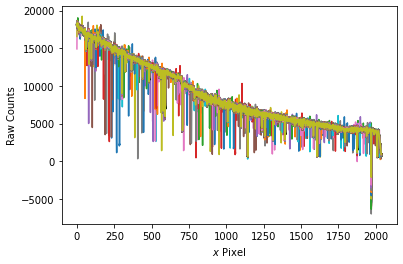

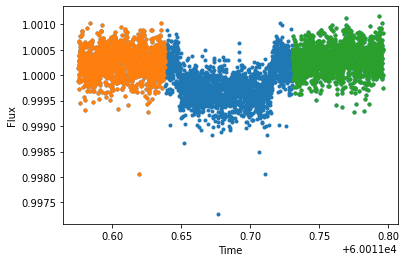

Sdev before tilt (pre transit) =  274.6893256342304  ppm
Sdev after tilt (post transit) =  263.9228872399523  ppm


In [15]:
upper_ap, lower_ap, trace_pos = np.loadtxt('NRS2_aperture.txt', unpack=True)

data_files_path = stage_1_dir #point to where the data is
rateints_files_nrs1 = glob.glob(data_files_path+'*nrs2_stage_1.fits')

ancillary_files = ancillary_dir
times = np.loadtxt(ancillary_files + 'jw02512010001_04102_0000_nrs2_all_segs_times.txt')

midtime_bjd = times[:,5]

# Get the integration time from the time file for error calculation
integration_time = np.median(abs((times[:,4]-times[:,6])*24*60*60))

trimming = 5

sci_cube, _ = jedi.unsegment(sorted(rateints_files_nrs1), 1)
sci_cube = sci_cube[:,:,trimming:-5]

all_spectra, _, _, _ = jedi.get_stellar_spectra(sci_cube, upper_ap+1, lower_ap+3, \
                                                          flat=None, f_mask=None, \
                                                          extract_method="intrapixel",  \
                                                          shift=False, plot=False, set_to_edge = True)


pre_transit = 1500 # These should be specific to your observation
pst_transit = 3700

lc = np.sum(all_spectra, axis=1)/np.sum(all_spectra[-1])

plt.figure()
plt.plot(midtime_bjd[10:], lc[10:], ls='none',marker='.')

plt.plot(midtime_bjd[10:pre_transit], lc[10:pre_transit], ls='none',marker='.')
plt.plot(midtime_bjd[pst_transit:], lc[pst_transit:], ls='none',marker='.')


plt.xlabel("Time")
plt.ylabel("Flux")

plt.show()

sdev_lcs = np.std(lc[10:pre_transit])
sdev_lce = np.std(lc[pst_transit:])

print('Sdev before tilt (pre transit) = ', sdev_lcs*1e6, ' ppm')
print('Sdev after tilt (post transit) = ', sdev_lce*1e6, ' ppm')